# Model Evaluation

#### Introduction

In this project, there are totally 9 datasets, each set of dataset are generated according to 3 different random states and 3 dimensions.    
   1. random seed: [None, 44, 37]
   2. dimension: [128, 96, 64]

This junyper notebook is a sample walkthrough the evaluation steps on ONLY 3 datasets with random seed 37. Each dataset would be split and trained by all candidate classifiers, namely Bagging SVM, Random Forest and Random Classifier. And finally each model candidate classifiers would be tested on dataset.

User can use this notebook to obtain the performance of other datasets with different random seed by inputting the correct dataset file name. 

The walkthorough assumed the performance data on other datasets were ready. So in the final visualisation, the chart could aggregate all the results from all 9 datasets. 

#### Evaluation of model performance:

Input:	datasets, hyperparameters of candidate models for evaluation, performance scorers

Process:	

-	Configuration scorers
-	For each datasets, split to training and testing dataset
-	Generate 25 random seeds, train PU learning classifiers of the top performing models found during the Grid Search Cross Validation
-	Build random classifier for comparison. 
-	Evaluate models performance on testing dataset, score the performance by scorers

Quality control:

-	Manual check the exported evaluation model file names are correct
-	Sample some model prediction. Inspect the prediction by domain expect to see those predictions make sense
-	Evaluate the processing time that should be reasonable

Output:	

-	Visualise all model performance in the batch of dataset, against each scorer
-	Visualise the aggregated performance of all models across all datasets, against each scorers

Remarks: User can change the dataset file names and obtain the models performance data on those datasets. 

##### Feature importance:  

Input:	a trained random forest model

Process:	for each tree in the random forest, calculate the average of the feature importance score of each feature

Output:	a plot to show the average contribution (0.0-1.0) of each feature vector to the classification



#### Import Libraries

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pulearn import BaggingPuClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, make_scorer, average_precision_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns


#### Define helper functions

In [3]:
# defined performance metrics scorers

def auprc_score(y_true, y_pred):
    '''
    scoring function of AUPRC
    parametes:
        y_true: pandas series, series of value of the class label
        y_pred: numpy array, the predicted probality of positive class
    return:
        AUPRC value
    '''
    return average_precision_score(y_true, y_pred)

def topk(y_true, y_pred, top_k=100, get_mask=False):
    '''
    scoring function of top k hit. 
    sort the prediction probability, from the toppest k predictions, count the numbers of true positives being predicted
    parametes:
        y_true: pandas series, series of true label
        y_pred: numpy array, the predicted probality of positive class
        top_k: int, the k value to be set for the scorer for calculating how many hits on the toppest k predictions
        get_mask: bool, to control the function to export number of hits or the positive mask of the top k predictions
    return:
        if get_mask is false: return top k hit score
        if get_mask is true: return the positve mask 
    '''
    sorted_indices = y_pred.argsort()[::-1]
    top_k_indices = sorted_indices[:top_k]
    y_pred_top_k_mask = np.full(y_true.shape, False, dtype=bool)
    y_pred_top_k_mask[top_k_indices] = True
    top_k_hits = y_true.values[y_pred_top_k_mask].sum()
    
    if get_mask == False:
        return top_k_hits
    else: 
        return y_pred_top_k_mask

# define evaluation function

def evaluate(model, test_X, test_y, scorers):
    '''
    use the input model to make prediction on the given dataset and score the performance by the input scorers
    parametes:
        model: BaggingPUClassifier object, the candidate model to be evaluated
        test_X: pandas dataframe object, testing data
        test_y: pandas dataframe object, true lable of testing data
        scorers: list of tuples. Each tuple consists of scorer name, scoring function, and the keyword args. 
    return:
        scores, dictionary, the score of respective scorers. 
    '''
    # Using a dictionary to store scores associated with each scorer's name
    y_pred = model.predict_proba(test_X)[:,1]
    scores = {name: [] for name, _, _ in scorers}

    for name, scorer, scorer_args in scorers:
        score = scorer(y_true=test_y, y_pred=y_pred, **scorer_args)
        scores[name]=score

    return scores

In [4]:
def evaluate_models(models, models_name, train_X, train_y, test_X, test_y, scorers_with_args, eval_models_path, eval_results_path):
    '''
    - train the list of models from the given training dataset and evaluate the predictions performance on the given testing data,
    - score the performance by the input scorers
    - and export the trained models and the performance results to the designated path
    
    parametes:
        models: list of BaggingPUClassifier objects, models for evaluation
        models_name: string, the common name of the model list
        train_X: pandas dataframe object, training data
        train_y: pandas dataframe object, true lable of training data
        test_X: pandas dataframe object, testing data
        test_y: pandas dataframe object, true lable of testing data
        scorers_with_args: list of tuples. Each tuple consists of scorer name, scoring function, and the keyword args
        eval_models_path: string, the path to store the trained models
        eval_results_path: string, the path to store the score of the respective scores
    return:
        None
    '''
    results = []

    for model in models:
        model.fit(train_X, train_y)

    eval_models_file_name = models_name + '.pickle'
    eval_models_file_path = os.path.join(eval_models_path, eval_models_file_name)

    with open(eval_models_file_path, 'wb') as f:
        pickle.dump(models, f, pickle.HIGHEST_PROTOCOL)

    for model in models:
        result_for_a_model = evaluate(model, test_X, test_y, scorers_with_args)
        print(result_for_a_model)
        results.append(result_for_a_model)

    results_df = pd.DataFrame(results)
    eval_results_file_name = 'eval_result_' + models_name + '.csv'
    eval_results_file_path = os.path.join(eval_results_path, eval_results_file_name)

    results_df.to_csv(eval_results_file_path, index=False)

In [7]:
def get_avg_feature_importances (models):
    '''
    Iterate all Bagging classifers in the model list. For example if the bagging classifier is Random Forest, 
    this function obtain the feature importance from the decision trees in the emsemble, 
    and average the feature importance of each random forest model, 
    and then average the feature importance of all random forest models. 
    The base classifier of the input models must implement feature_importance method. 
    
    parametes:
        models: list of BaggingPUClassifier objects, models that's base classifier implemented feature_importance method. For example, base classifier is Decision Tree
    return:
        sorted_means: pandas dataframe, sorted order of the feature name and its importance value [0.0-1.0] in descending order 
    '''

    all_rf_importances = []

    for idx, model in enumerate(models):
        clf = model.named_steps['clf']
        feature_importances = [estimator.feature_importances_ for estimator in clf.estimators_]
        df_feature_importances = pd.DataFrame(feature_importances)
        feature_importances_means = df_feature_importances.mean()
        all_rf_importances.append(feature_importances_means)

    # Convert list of feature importances to a DataFrame
    df_all_rf_importances = pd.concat(all_rf_importances, axis=1).T

    # Calculate the mean feature importance across all models
    average_importance = df_all_rf_importances.mean()

    # Sort by descending importance
    sorted_means = average_importance.sort_values(ascending=False)
    
    return sorted_means

In [5]:
np.set_printoptions(precision=10)

#### Evaluate Candidate PU Learning Models

In [7]:
# generate 25 random seeds

eva_rounds = 25

np.random.seed(44)
random_states = [np.random.randint(0, 99) for _ in range(eva_rounds)]
print("random_states be used: ", random_states)
    

random_states be used:  [20, 35, 45, 59, 3, 96, 84, 3, 23, 55, 22, 89, 67, 71, 67, 57, 1, 14, 36, 93, 85, 83, 96, 74, 36]


In [8]:
# configure scorers and parameters 
scorers_with_args = [
    ('top_20', topk, {'top_k': 20}),
    ('top_100', topk, {'top_k': 100}),
    ('auprc', auprc_score, {})
]

In [9]:
# set the path to store the trained models and its performance result
eval_models_path = os.path.join('eval_models')
eval_results_path = os.path.join('eval_results')

#### Evaluate on one dataset (d=128, randome seed = 37)

In [10]:
# load the subject dataset

dataset_filename = 'dataset_p_4_q_1_dim_128_walkleng_100_numwalks_500_seed_37.csv'

file_path = os.path.join('data', 'datasets', dataset_filename)
dataset = pd.read_csv(file_path)

#### Splitting the dataset

In [11]:
# X is the data of feature1 to feature128 in the dataset
X = dataset.drop(['id', 'y'], axis=1)
# y is the target value of the last column in the dataset
y = dataset['y']

# split the dataset into training and testing with 80% to 20% proportion and randomly shuffle the data
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=37,stratify=y)

train_indices = train_X.index
test_indices = test_X.index

# print the shape of the data
print(f'Training dataset shape, X: {train_X.shape}')
print(f'Training dataset shape, y: {train_y.shape}')
print(f'Testing dataset shape, X: {test_X.shape}')
print(f'Testing dataset shape, y: {test_y.shape}')

Training dataset shape, X: (12968, 128)
Training dataset shape, y: (12968,)
Testing dataset shape, X: (3242, 128)
Testing dataset shape, y: (3242,)


#### Train and Test on candidates classifiers

For each candidate:

    - create 25 classifiers
    - train each classifier on the training set
    - test each classifier on the testing set
    - evaluate performance by each scorer

 

In [12]:
models_name = 'models_svm_1_' + os.path.splitext(dataset_filename)[0]

In [11]:
models_svm_1 = []

# generate models for evaluation

for random_state in random_states:
    base_clf = SVC(C=3)
    clf = BaggingPuClassifier(n_estimators =200, max_samples= 600, max_features = 0.75, base_estimator=base_clf, n_jobs = -1, random_state= random_state, verbose=0)
    scaler = StandardScaler()
    model = Pipeline([
                    ("scale", scaler),
                    ("clf", clf)
                    ])
    models_svm_1.append(model)

for model in models_svm_1:
    model.fit(train_X, train_y)

c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

In [12]:
eval_models_file_name = models_name + '.pickle'
eval_models_file_path = os.path.join(eval_models_path, eval_models_file_name)

with open(eval_models_file_path, 'wb') as f:
    pickle.dump(models_svm_1, f, pickle.HIGHEST_PROTOCOL)

In [13]:
results = []

for model in models_svm_1:
    result_for_a_model = evaluate(model, test_X, test_y, scorers_with_args)
    print(result_for_a_model)
    results.append(result_for_a_model)

results_svm_df_1 = pd.DataFrame(results)

{'top_20': 7, 'top_100': 21, 'auprc': 0.15300432459924915}
{'top_20': 8, 'top_100': 22, 'auprc': 0.15790320323717671}
{'top_20': 6, 'top_100': 23, 'auprc': 0.15349082084216384}
{'top_20': 6, 'top_100': 23, 'auprc': 0.15694197892048944}
{'top_20': 6, 'top_100': 23, 'auprc': 0.14699936711003758}
{'top_20': 5, 'top_100': 22, 'auprc': 0.14769187497333996}
{'top_20': 9, 'top_100': 24, 'auprc': 0.15408080190306953}
{'top_20': 6, 'top_100': 23, 'auprc': 0.14699936711003758}
{'top_20': 9, 'top_100': 22, 'auprc': 0.1532491818871558}
{'top_20': 8, 'top_100': 23, 'auprc': 0.16129547660051813}
{'top_20': 6, 'top_100': 25, 'auprc': 0.1653572319642752}
{'top_20': 5, 'top_100': 22, 'auprc': 0.14823229211841188}
{'top_20': 5, 'top_100': 22, 'auprc': 0.1594685977627617}
{'top_20': 6, 'top_100': 24, 'auprc': 0.15439228480362024}
{'top_20': 5, 'top_100': 22, 'auprc': 0.1594685977627617}
{'top_20': 5, 'top_100': 22, 'auprc': 0.1614003038119546}
{'top_20': 7, 'top_100': 21, 'auprc': 0.14583111794988}
{'top

In [14]:
eval_results_file_name = 'eval_result_' + models_name + '.csv'
eval_results_file_path = os.path.join(eval_results_path, eval_results_file_name)

results_svm_df_1.to_csv(eval_results_file_path, index=False)

##### Retrieve samples prediction (top_20) from models for inspection

Inspecting:
- validate the number of predictions, it should be 3242 (total size of testing set)
- validate the number of predictions, it should be 71 (total size of positive in testing set)
- share the prediction to domain expert to check if those predictions are sensible

In [13]:
# load the trained models, models_svm_1 in this example case.
sample_models_files = 'models_svm_1_dataset_p_4_q_1_dim_128_walkleng_100_numwalks_500_seed_37.pickle'

with open(os.path.join(eval_models_path, sample_models_files), 'rb') as f:
        models_svm_1 = pickle.load(f)

In [14]:
models = models_svm_1

testing_set_samples_model = []
testing_set_samples_model_top_20_mask = []

# set the number of samples to retrieve, the number should be in range from 1 to 25
num_sample = 3

for i in range(num_sample):
    y_pred = models[i].predict_proba(test_X)[:,1]
    testing_set_samples_model.append(y_pred)
    testing_set_samples_model_top_20_mask.append(topk(test_y, y_pred, top_k=20, get_mask=True))
    
id_series = dataset.iloc[test_X.index].id

In [18]:
sample_check_model_test_X_pred_proba = pd.DataFrame()
sample_check_model_test_X_pred_proba['id'] = id_series
sample_check_model_test_X_pred_proba['y'] = test_y
for i in range(num_sample):
    sample_check_model_test_X_pred_proba[f'models_sample_{i}_predict_proba'] = testing_set_samples_model[i]
    sample_check_model_test_X_pred_proba[f'models_sample_{i}_top_20_mask'] = testing_set_samples_model_top_20_mask[i]

In [19]:
# preview the predicted probabality 
sample_check_model_test_X_pred_proba

,id,y,models_sample_0_predict_proba,models_sample_0_top_20_mask,models_sample_1_predict_proba,models_sample_1_top_20_mask,models_sample_2_predict_proba,models_sample_2_top_20_mask
14643,ENSG00000007376,0,0.155,False,0.170,False,0.180,False
10150,ENSG00000169435,0,0.085,False,0.040,False,0.070,False
12511,ENSG00000139697,0,0.000,False,0.000,False,0.000,False
13381,ENSG00000137200,0,0.000,False,0.000,False,0.000,False
4313,ENSG00000143862,0,0.290,False,0.290,False,0.345,False
...,...,...,...,...,...,...,...,...
2771,ENSG00000123570,0,0.015,False,0.015,False,0.010,False
1616,ENSG00000174417,0,0.025,False,0.020,False,0.005,False
7011,ENSG00000134882,1,0.005,False,0.005,False,0.005,False
7009,ENSG00000174917,0,0.010,False,0.010,False,0.000,False


In [20]:
# store the samples
sample_check_model_test_X_pred_proba.to_csv(os.path.join('inspection', 'top20_samples_' + os.path.splitext(sample_models_files)[0] + '.csv'))

#### Repeat the similar steps to Train and Test on the rest candidates classifiers

In [15]:
models_name = 'models_svm_2_' + os.path.splitext(dataset_filename)[0]

In [16]:
# tried on another best estimator candidate with max_sample=700

models_svm_2 = []

# generate evaluation models

for random_state in random_states:
    base_clf = SVC(C=3)
    clf = BaggingPuClassifier(n_estimators =200, max_samples= 700, max_features = 0.75, base_estimator=base_clf, n_jobs = -1, random_state= random_state, verbose=0)
    scaler = StandardScaler()
    model = Pipeline([
                    ("scale", scaler),
                    ("clf", clf)
                    ])
    models_svm_2.append(model)

for model in models_svm_2:
    model.fit(train_X, train_y)

c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

In [17]:
eval_models_file_name = models_name + '.pickle'
eval_models_file_path = os.path.join(eval_models_path, eval_models_file_name)

with open(eval_models_file_path, 'wb') as f:
    pickle.dump(models_svm_1, f, pickle.HIGHEST_PROTOCOL)

In [18]:
results = []

for model in models_svm_2:
    result_for_a_model = evaluate(model, test_X, test_y, scorers_with_args)
    print(result_for_a_model)
    results.append(result_for_a_model)

results_svm_df_2 = pd.DataFrame(results)

{'top_20': 7, 'top_100': 22, 'auprc': 0.15907852687167046}
{'top_20': 9, 'top_100': 23, 'auprc': 0.16365263911284084}
{'top_20': 7, 'top_100': 23, 'auprc': 0.1659064601209324}
{'top_20': 7, 'top_100': 24, 'auprc': 0.16841944169275583}
{'top_20': 8, 'top_100': 23, 'auprc': 0.16029299453272894}
{'top_20': 9, 'top_100': 21, 'auprc': 0.17495193945049312}
{'top_20': 7, 'top_100': 22, 'auprc': 0.16189124696348725}
{'top_20': 8, 'top_100': 23, 'auprc': 0.16029299453272894}
{'top_20': 10, 'top_100': 23, 'auprc': 0.17301923407370778}
{'top_20': 10, 'top_100': 21, 'auprc': 0.1798938501388419}
{'top_20': 9, 'top_100': 25, 'auprc': 0.18351516373421217}
{'top_20': 5, 'top_100': 23, 'auprc': 0.1623432412326679}
{'top_20': 8, 'top_100': 21, 'auprc': 0.16181838261558806}
{'top_20': 9, 'top_100': 23, 'auprc': 0.17109278994535126}
{'top_20': 8, 'top_100': 21, 'auprc': 0.16181838261558806}
{'top_20': 10, 'top_100': 24, 'auprc': 0.16775193511761327}
{'top_20': 9, 'top_100': 21, 'auprc': 0.1611558854026943

In [19]:
eval_results_file_name = 'eval_result_' + models_name + '.csv'
eval_results_file_path = os.path.join(eval_results_path, eval_results_file_name)

results_svm_df_2.to_csv(eval_results_file_path, index=False)

#### Below is the simplied codes of models training and evaluation

In [20]:
models_name = 'models_rf_1_' + os.path.splitext(dataset_filename)[0]

models = []

for random_state in random_states:
    base_clf = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=120, min_samples_leaf=2, min_samples_split=2)
    clf = BaggingPuClassifier(n_estimators =200, max_samples= 600, base_estimator=base_clf, n_jobs = -1, random_state= random_state, verbose=0)
    scaler = StandardScaler()
    model = Pipeline([
                    ("scale", scaler),
                    ("clf", clf)
                    ])
    models.append(model)

evaluate_models(models, models_name, train_X, train_y, test_X, test_y, scorers_with_args, eval_models_path, eval_results_path)

c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

{'top_20': 4, 'top_100': 23, 'auprc': 0.1467609170061578}
{'top_20': 4, 'top_100': 25, 'auprc': 0.14649288583694797}
{'top_20': 4, 'top_100': 23, 'auprc': 0.1523085946934784}
{'top_20': 5, 'top_100': 22, 'auprc': 0.14439058668724583}
{'top_20': 5, 'top_100': 23, 'auprc': 0.14939435901255493}
{'top_20': 5, 'top_100': 23, 'auprc': 0.1446309576107267}
{'top_20': 3, 'top_100': 22, 'auprc': 0.13369941947132075}
{'top_20': 5, 'top_100': 23, 'auprc': 0.14939435901255493}
{'top_20': 4, 'top_100': 25, 'auprc': 0.14086384928188}
{'top_20': 4, 'top_100': 24, 'auprc': 0.13138542152154328}
{'top_20': 5, 'top_100': 22, 'auprc': 0.14260019525125486}
{'top_20': 5, 'top_100': 23, 'auprc': 0.14360098994253534}
{'top_20': 5, 'top_100': 23, 'auprc': 0.1511268254873056}
{'top_20': 4, 'top_100': 21, 'auprc': 0.15504787468752576}
{'top_20': 5, 'top_100': 23, 'auprc': 0.1511268254873056}
{'top_20': 5, 'top_100': 26, 'auprc': 0.1477469012862166}
{'top_20': 4, 'top_100': 24, 'auprc': 0.1552663959948345}
{'top_2

In [21]:
models_name = 'models_rf_2_' + os.path.splitext(dataset_filename)[0]

models = []

for random_state in random_states:
    base_clf = DecisionTreeClassifier(max_depth=12, max_leaf_nodes=120, min_samples_leaf=2, min_samples_split=2)
    clf = BaggingPuClassifier(n_estimators =200, max_samples= 600, base_estimator=base_clf, n_jobs = -1, random_state= random_state, verbose=0)
    scaler = StandardScaler()
    model = Pipeline([
                    ("scale", scaler),
                    ("clf", clf)
                    ])
    models.append(model)

evaluate_models(models, models_name, train_X, train_y, test_X, test_y, scorers_with_args, eval_models_path, eval_results_path)

c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

{'top_20': 4, 'top_100': 23, 'auprc': 0.14449511130422105}
{'top_20': 3, 'top_100': 25, 'auprc': 0.1510416384084657}
{'top_20': 5, 'top_100': 23, 'auprc': 0.15329738119138916}
{'top_20': 5, 'top_100': 21, 'auprc': 0.14049930782879036}
{'top_20': 5, 'top_100': 23, 'auprc': 0.14899235520578052}
{'top_20': 5, 'top_100': 23, 'auprc': 0.14683174328344006}
{'top_20': 3, 'top_100': 22, 'auprc': 0.13688009894246703}
{'top_20': 5, 'top_100': 23, 'auprc': 0.14899235520578052}
{'top_20': 4, 'top_100': 24, 'auprc': 0.13819750695213873}
{'top_20': 5, 'top_100': 23, 'auprc': 0.13352121490629704}
{'top_20': 6, 'top_100': 22, 'auprc': 0.14512328567653518}
{'top_20': 4, 'top_100': 23, 'auprc': 0.13694281079410042}
{'top_20': 5, 'top_100': 22, 'auprc': 0.15260065285949873}
{'top_20': 4, 'top_100': 21, 'auprc': 0.15747537273985174}
{'top_20': 5, 'top_100': 22, 'auprc': 0.15260065285949873}
{'top_20': 5, 'top_100': 24, 'auprc': 0.14923393133476504}
{'top_20': 4, 'top_100': 24, 'auprc': 0.1546062512643336}

#### Test with Random Classifier

In [100]:
class RandomClassifier:
    def __init__(self, pos_threshold=0.5, random_state=None):
        self.pos_threshold = pos_threshold
        self.random_state = random_state
        self.rng = np.random.default_rng(seed=random_state)
        self._last_proba = None

    def fit(self, X, y):
        pass

    def predict_proba(self, X):
        n_samples = len(X)
        positive_proba = self.rng.random(n_samples)
        negative_proba = 1 - positive_proba
        self._last_proba = np.column_stack((negative_proba, positive_proba))
        return self._last_proba
    
    def predict(self, X):
        if self._last_proba is None or len(X) != len(self._last_proba):
            pos_proba = self.predict_proba(X)[:, 1]
        else:
            pos_proba = self._last_proba[:, 1]
        
        np.savetxt('check.csv', pos_proba, delimiter=',')
        cutoff_index = int(len(pos_proba) * (1 - self.pos_threshold))
        threshold_value = np.sort(pos_proba)[cutoff_index]
        print(threshold_value)
        predictions = (pos_proba >= threshold_value).astype(int)  # 1 if True, 0 if False
        return predictions

In [23]:
models_name = 'models_rc_' + os.path.splitext(dataset_filename)[0]

models = []

for random_state in random_states:
    clf = RandomClassifier(pos_threshold=0.0219, random_state= random_state)
    models.append(clf)

results = []

for model in models:
    result_for_a_model = evaluate(model, test_X, test_y, scorers_with_args)
    results.append(result_for_a_model)

results_df = pd.DataFrame(results)

eval_results_file_name = 'eval_result_' + models_name + '.csv'
eval_results_file_path = os.path.join(eval_results_path, eval_results_file_name)

results_df.to_csv(eval_results_file_path, index=False)

#### Repeat the evaluation steps for the next datasets (d=96, random seed = 37)

#### Loading the dataset (d=96, random seed = 37)

In [61]:
# load datasets

dataset_filename = 'dataset_p_4_q_1_dim_96_walkleng_100_numwalks_500_seed_37.csv'

file_path = os.path.join('data', 'datasets', dataset_filename)
dataset = pd.read_csv(file_path)

#### Splitting the dataset

In [62]:
# X is the data of feature1 to feature96 in the dataset
X = dataset.drop(['id', 'y'], axis=1)
# y is the target value of the last column in the dataset
y = dataset['y']

# split the dataset into training and testing with 80% to 20% proportion and randomly shuffle the data
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=37,stratify=y)

train_indices = train_X.index
test_indices = test_X.index

# print the shape of the data
print(f'Training dataset shape, X: {train_X.shape}')
print(f'Training dataset shape, y: {train_y.shape}')
print(f'Testing dataset shape, X: {test_X.shape}')
print(f'Testing dataset shape, y: {test_y.shape}')

Training dataset shape, X: (12968, 96)
Training dataset shape, y: (12968,)
Testing dataset shape, X: (3242, 96)
Testing dataset shape, y: (3242,)


In [26]:
models_name = 'models_svm_1_' + os.path.splitext(dataset_filename)[0]

models = []

for random_state in random_states:
    base_clf = SVC(C=3)
    clf = BaggingPuClassifier(n_estimators =200, max_samples= 600, max_features = 0.75, base_estimator=base_clf, n_jobs = -1, random_state= random_state, verbose=0)
    scaler = StandardScaler()
    model = Pipeline([
                    ("scale", scaler),
                    ("clf", clf)
                    ])
    models.append(model)

evaluate_models(models, models_name, train_X, train_y, test_X, test_y, scorers_with_args, eval_models_path, eval_results_path)


c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

{'top_20': 7, 'top_100': 19, 'auprc': 0.12866002120292647}
{'top_20': 6, 'top_100': 20, 'auprc': 0.12636732099054734}
{'top_20': 6, 'top_100': 19, 'auprc': 0.13679891607908312}
{'top_20': 5, 'top_100': 19, 'auprc': 0.12888159554508197}
{'top_20': 5, 'top_100': 18, 'auprc': 0.1318328779486287}
{'top_20': 5, 'top_100': 19, 'auprc': 0.12415259325577119}
{'top_20': 5, 'top_100': 18, 'auprc': 0.13401887391574183}
{'top_20': 5, 'top_100': 18, 'auprc': 0.1318328779486287}
{'top_20': 6, 'top_100': 20, 'auprc': 0.1353304142570769}
{'top_20': 7, 'top_100': 19, 'auprc': 0.12888782020745704}
{'top_20': 6, 'top_100': 19, 'auprc': 0.12961063999311795}
{'top_20': 6, 'top_100': 18, 'auprc': 0.13140693123424207}
{'top_20': 7, 'top_100': 18, 'auprc': 0.13411076827677426}
{'top_20': 6, 'top_100': 19, 'auprc': 0.13379445341247576}
{'top_20': 7, 'top_100': 18, 'auprc': 0.13411076827677426}
{'top_20': 4, 'top_100': 18, 'auprc': 0.1251938993440821}
{'top_20': 7, 'top_100': 18, 'auprc': 0.13527046100786005}
{

In [ ]:
models_name = 'models_svm_2_' + os.path.splitext(dataset_filename)[0]

models = []

for random_state in random_states:
    base_clf = SVC(C=3)
    clf = BaggingPuClassifier(n_estimators =200, max_samples= 700, max_features = 0.75, base_estimator=base_clf, n_jobs = -1, random_state= random_state, verbose=0)
    scaler = StandardScaler()
    model = Pipeline([
                    ("scale", scaler),
                    ("clf", clf)
                    ])
    models.append(model)

evaluate_models(models, models_name, train_X, train_y, test_X, test_y, scorers_with_args, eval_models_path, eval_results_path)

c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

{'top_20': 7, 'top_100': 19, 'auprc': 0.12578184062194334}
{'top_20': 6, 'top_100': 18, 'auprc': 0.12660841503204628}
{'top_20': 8, 'top_100': 19, 'auprc': 0.13322380954465168}
{'top_20': 7, 'top_100': 18, 'auprc': 0.13237618580099517}
{'top_20': 8, 'top_100': 19, 'auprc': 0.13237029749207133}
{'top_20': 5, 'top_100': 19, 'auprc': 0.12211074748257622}
{'top_20': 8, 'top_100': 19, 'auprc': 0.1360359731024493}
{'top_20': 8, 'top_100': 19, 'auprc': 0.13237029749207133}
{'top_20': 6, 'top_100': 18, 'auprc': 0.13080152572069897}
{'top_20': 6, 'top_100': 19, 'auprc': 0.12968091927820552}
{'top_20': 9, 'top_100': 18, 'auprc': 0.1365801718060176}
{'top_20': 7, 'top_100': 18, 'auprc': 0.1298454245660674}
{'top_20': 4, 'top_100': 17, 'auprc': 0.12195819142216598}
{'top_20': 5, 'top_100': 17, 'auprc': 0.1328898532425496}
{'top_20': 4, 'top_100': 17, 'auprc': 0.12195819142216598}
{'top_20': 5, 'top_100': 18, 'auprc': 0.12908929040232192}
{'top_20': 6, 'top_100': 18, 'auprc': 0.13095887805575618}
{

In [18]:
models_name = 'models_rf_1_' + os.path.splitext(dataset_filename)[0]

models = []

for random_state in random_states:
    base_clf = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=120, min_samples_leaf=2, min_samples_split=2)
    clf = BaggingPuClassifier(n_estimators =200, max_samples= 600, base_estimator=base_clf, n_jobs = -1, random_state= random_state, verbose=0)
    scaler = StandardScaler()
    model = Pipeline([
                    ("scale", scaler),
                    ("clf", clf)
                    ])
    models.append(model)

evaluate_models(models, models_name, train_X, train_y, test_X, test_y, scorers_with_args, eval_models_path, eval_results_path)

c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

{'top_20': 6, 'top_100': 21, 'auprc': 0.13772791906694432}
{'top_20': 5, 'top_100': 22, 'auprc': 0.13529589899333117}
{'top_20': 5, 'top_100': 20, 'auprc': 0.14049057902951195}
{'top_20': 7, 'top_100': 22, 'auprc': 0.15265752804976268}
{'top_20': 5, 'top_100': 21, 'auprc': 0.14937499900606366}
{'top_20': 5, 'top_100': 21, 'auprc': 0.14226005687763782}
{'top_20': 6, 'top_100': 21, 'auprc': 0.14511216632286364}
{'top_20': 5, 'top_100': 21, 'auprc': 0.14937499900606366}
{'top_20': 6, 'top_100': 21, 'auprc': 0.13966055869448213}
{'top_20': 6, 'top_100': 22, 'auprc': 0.14844733594922}
{'top_20': 6, 'top_100': 21, 'auprc': 0.14454999512939393}
{'top_20': 6, 'top_100': 21, 'auprc': 0.1462412234281281}
{'top_20': 4, 'top_100': 21, 'auprc': 0.13716820705022031}
{'top_20': 5, 'top_100': 22, 'auprc': 0.14121752838354185}
{'top_20': 4, 'top_100': 21, 'auprc': 0.13716820705022031}
{'top_20': 5, 'top_100': 23, 'auprc': 0.14378742756159582}
{'top_20': 5, 'top_100': 21, 'auprc': 0.13868458982882068}
{

In [ ]:
models_name = 'models_rf_2_' + os.path.splitext(dataset_filename)[0]

models = []

for random_state in random_states:
    base_clf = DecisionTreeClassifier(max_depth=12, max_leaf_nodes=120, min_samples_leaf=2, min_samples_split=2)
    clf = BaggingPuClassifier(n_estimators =200, max_samples= 600, base_estimator=base_clf, n_jobs = -1, random_state= random_state, verbose=0)
    scaler = StandardScaler()
    model = Pipeline([
                    ("scale", scaler),
                    ("clf", clf)
                    ])
    models.append(model)

evaluate_models(models, models_name, train_X, train_y, test_X, test_y, scorers_with_args, eval_models_path, eval_results_path)

In [29]:
models_name = 'models_rf_2_' + os.path.splitext(dataset_filename)[0]

models = []

for random_state in random_states:
    base_clf = DecisionTreeClassifier(max_depth=12, max_leaf_nodes=120, min_samples_leaf=2, min_samples_split=2)
    clf = BaggingPuClassifier(n_estimators =200, max_samples= 600, base_estimator=base_clf, n_jobs = -1, random_state= random_state, verbose=0)
    scaler = StandardScaler()
    model = Pipeline([
                    ("scale", scaler),
                    ("clf", clf)
                    ])
    models.append(model)

evaluate_models(models, models_name, train_X, train_y, test_X, test_y, scorers_with_args, eval_models_path, eval_results_path)

c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

{'top_20': 6, 'top_100': 21, 'auprc': 0.13390557795766103}
{'top_20': 5, 'top_100': 23, 'auprc': 0.13740701873369404}
{'top_20': 6, 'top_100': 20, 'auprc': 0.14920652180531285}
{'top_20': 6, 'top_100': 22, 'auprc': 0.15141848877117173}
{'top_20': 5, 'top_100': 22, 'auprc': 0.15009130617187152}
{'top_20': 5, 'top_100': 21, 'auprc': 0.14533079998924422}
{'top_20': 4, 'top_100': 22, 'auprc': 0.14300028397415127}
{'top_20': 5, 'top_100': 22, 'auprc': 0.15009130617187152}
{'top_20': 6, 'top_100': 21, 'auprc': 0.14549019510470682}
{'top_20': 7, 'top_100': 22, 'auprc': 0.1474495438542645}
{'top_20': 6, 'top_100': 23, 'auprc': 0.14229799909353197}
{'top_20': 5, 'top_100': 23, 'auprc': 0.14248526154820404}
{'top_20': 5, 'top_100': 21, 'auprc': 0.1372189203500044}
{'top_20': 5, 'top_100': 22, 'auprc': 0.13804410642404757}
{'top_20': 5, 'top_100': 21, 'auprc': 0.1372189203500044}
{'top_20': 5, 'top_100': 22, 'auprc': 0.1434955995691826}
{'top_20': 5, 'top_100': 21, 'auprc': 0.1434420958417326}
{'

In [30]:
models_name = 'models_rc_' + os.path.splitext(dataset_filename)[0]

models = []

for random_state in random_states:
    clf = RandomClassifier(pos_threshold=0.0219, random_state= random_state)
    models.append(clf)

results = []

for model in models:
    result_for_a_model = evaluate(model, test_X, test_y, scorers_with_args)
    results.append(result_for_a_model)

results_df = pd.DataFrame(results)

eval_results_file_name = 'eval_result_' + models_name + '.csv'
eval_results_file_path = os.path.join(eval_results_path, eval_results_file_name)

results_df.to_csv(eval_results_file_path, index=False)

#### Repeat the evaluation steps for the next datasets (d=64, random seed = 37)

In [31]:
# load datasets

dataset_filename = 'dataset_p_4_q_1_dim_64_walkleng_100_numwalks_500_seed_37.csv'

file_path = os.path.join('data', 'datasets', dataset_filename)
dataset = pd.read_csv(file_path)

#### Splitting the dataset

In [32]:
# X is the data of feature1 to feature64 in the dataset
X = dataset.drop(['id', 'y'], axis=1)
# y is the target value of the last column in the dataset
y = dataset['y']

# split the dataset into training and testing with 80% to 20% proportion and randomly shuffle the data
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=37,stratify=y)

train_indices = train_X.index
test_indices = test_X.index

# print the shape of the data
print(f'Training dataset shape, X: {train_X.shape}')
print(f'Training dataset shape, y: {train_y.shape}')
print(f'Testing dataset shape, X: {test_X.shape}')
print(f'Testing dataset shape, y: {test_y.shape}')

Training dataset shape, X: (12968, 64)
Training dataset shape, y: (12968,)
Testing dataset shape, X: (3242, 64)
Testing dataset shape, y: (3242,)


In [33]:
models_name = 'models_svm_1_' + os.path.splitext(dataset_filename)[0]

models = []

for random_state in random_states:
    base_clf = SVC(C=3)
    clf = BaggingPuClassifier(n_estimators =200, max_samples= 600, max_features = 0.75, base_estimator=base_clf, n_jobs = -1, random_state= random_state, verbose=0)
    scaler = StandardScaler()
    model = Pipeline([
                    ("scale", scaler),
                    ("clf", clf)
                    ])
    models.append(model)

evaluate_models(models, models_name, train_X, train_y, test_X, test_y, scorers_with_args, eval_models_path, eval_results_path)


c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

{'top_20': 8, 'top_100': 27, 'auprc': 0.17012946021784128}
{'top_20': 6, 'top_100': 26, 'auprc': 0.16359036033783425}
{'top_20': 6, 'top_100': 27, 'auprc': 0.15003153787297116}
{'top_20': 7, 'top_100': 27, 'auprc': 0.1587792822231609}
{'top_20': 8, 'top_100': 27, 'auprc': 0.15612916265539817}
{'top_20': 5, 'top_100': 27, 'auprc': 0.1609182739688044}
{'top_20': 6, 'top_100': 27, 'auprc': 0.1644900206203259}
{'top_20': 8, 'top_100': 27, 'auprc': 0.15612916265539817}
{'top_20': 6, 'top_100': 26, 'auprc': 0.16701271102297244}
{'top_20': 5, 'top_100': 27, 'auprc': 0.15158027869823967}
{'top_20': 7, 'top_100': 25, 'auprc': 0.16049978262874992}
{'top_20': 8, 'top_100': 27, 'auprc': 0.1613826301105289}
{'top_20': 7, 'top_100': 27, 'auprc': 0.15331543443051443}
{'top_20': 7, 'top_100': 26, 'auprc': 0.15367986525265842}
{'top_20': 7, 'top_100': 27, 'auprc': 0.15331543443051443}
{'top_20': 6, 'top_100': 26, 'auprc': 0.1540996923438803}
{'top_20': 6, 'top_100': 26, 'auprc': 0.16668094291409052}
{'

In [34]:
models_name = 'models_svm_2_' + os.path.splitext(dataset_filename)[0]

models = []

for random_state in random_states:
    base_clf = SVC(C=3)
    clf = BaggingPuClassifier(n_estimators =200, max_samples= 700, max_features = 0.75, base_estimator=base_clf, n_jobs = -1, random_state= random_state, verbose=0)
    scaler = StandardScaler()
    model = Pipeline([
                    ("scale", scaler),
                    ("clf", clf)
                    ])
    models.append(model)

evaluate_models(models, models_name, train_X, train_y, test_X, test_y, scorers_with_args, eval_models_path, eval_results_path)

c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

{'top_20': 7, 'top_100': 26, 'auprc': 0.16020995106154975}
{'top_20': 7, 'top_100': 26, 'auprc': 0.1636356082128433}
{'top_20': 5, 'top_100': 26, 'auprc': 0.15121438542412613}
{'top_20': 8, 'top_100': 26, 'auprc': 0.16986772269022857}
{'top_20': 7, 'top_100': 26, 'auprc': 0.1668670993066999}
{'top_20': 8, 'top_100': 26, 'auprc': 0.16623524863682754}
{'top_20': 7, 'top_100': 27, 'auprc': 0.16873109052776966}
{'top_20': 7, 'top_100': 26, 'auprc': 0.1668670993066999}
{'top_20': 8, 'top_100': 26, 'auprc': 0.15339591444994638}
{'top_20': 6, 'top_100': 26, 'auprc': 0.1471960488774365}
{'top_20': 8, 'top_100': 25, 'auprc': 0.15803058097632658}
{'top_20': 5, 'top_100': 26, 'auprc': 0.15933204594241165}
{'top_20': 6, 'top_100': 26, 'auprc': 0.15993869167626887}
{'top_20': 6, 'top_100': 26, 'auprc': 0.15902010377314035}
{'top_20': 6, 'top_100': 26, 'auprc': 0.15993869167626887}
{'top_20': 8, 'top_100': 26, 'auprc': 0.16207409591317493}
{'top_20': 3, 'top_100': 25, 'auprc': 0.15155928437971952}
{

In [35]:
models_name = 'models_rf_1_' + os.path.splitext(dataset_filename)[0]

models = []

for random_state in random_states:
    base_clf = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=120, min_samples_leaf=2, min_samples_split=2)
    clf = BaggingPuClassifier(n_estimators =200, max_samples= 600, base_estimator=base_clf, n_jobs = -1, random_state= random_state, verbose=0)
    scaler = StandardScaler()
    model = Pipeline([
                    ("scale", scaler),
                    ("clf", clf)
                    ])
    models.append(model)

evaluate_models(models, models_name, train_X, train_y, test_X, test_y, scorers_with_args, eval_models_path, eval_results_path)

c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

{'top_20': 7, 'top_100': 24, 'auprc': 0.16962520393591876}
{'top_20': 6, 'top_100': 25, 'auprc': 0.17363542348593805}
{'top_20': 8, 'top_100': 25, 'auprc': 0.18279893826254734}
{'top_20': 6, 'top_100': 27, 'auprc': 0.1764169506939264}
{'top_20': 7, 'top_100': 26, 'auprc': 0.17325156194262198}
{'top_20': 6, 'top_100': 24, 'auprc': 0.17054258871614203}
{'top_20': 6, 'top_100': 24, 'auprc': 0.16342960088013825}
{'top_20': 7, 'top_100': 26, 'auprc': 0.17325156194262198}
{'top_20': 7, 'top_100': 24, 'auprc': 0.167415056254784}
{'top_20': 7, 'top_100': 25, 'auprc': 0.1774000240836281}
{'top_20': 6, 'top_100': 26, 'auprc': 0.1650457217821632}
{'top_20': 5, 'top_100': 25, 'auprc': 0.16328266584119408}
{'top_20': 6, 'top_100': 25, 'auprc': 0.16713602425479818}
{'top_20': 6, 'top_100': 26, 'auprc': 0.16575524028973418}
{'top_20': 6, 'top_100': 25, 'auprc': 0.16713602425479818}
{'top_20': 6, 'top_100': 24, 'auprc': 0.17138749371846265}
{'top_20': 5, 'top_100': 26, 'auprc': 0.16382986933271543}
{'

In [36]:
models_name = 'models_rf_2_' + os.path.splitext(dataset_filename)[0]

models = []

for random_state in random_states:
    base_clf = DecisionTreeClassifier(max_depth=12, max_leaf_nodes=120, min_samples_leaf=2, min_samples_split=2)
    clf = BaggingPuClassifier(n_estimators =200, max_samples= 600, base_estimator=base_clf, n_jobs = -1, random_state= random_state, verbose=0)
    scaler = StandardScaler()
    model = Pipeline([
                    ("scale", scaler),
                    ("clf", clf)
                    ])
    models.append(model)

evaluate_models(models, models_name, train_X, train_y, test_X, test_y, scorers_with_args, eval_models_path, eval_results_path)

c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ron\anaconda3\envs\PULearn\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

{'top_20': 6, 'top_100': 24, 'auprc': 0.17994988748029972}
{'top_20': 6, 'top_100': 26, 'auprc': 0.1772382617191269}
{'top_20': 8, 'top_100': 25, 'auprc': 0.17875523850098088}
{'top_20': 7, 'top_100': 25, 'auprc': 0.16587539974357782}
{'top_20': 7, 'top_100': 23, 'auprc': 0.17944777669696604}
{'top_20': 6, 'top_100': 23, 'auprc': 0.1718744881736285}
{'top_20': 7, 'top_100': 24, 'auprc': 0.16723246779619655}
{'top_20': 7, 'top_100': 23, 'auprc': 0.17944777669696604}
{'top_20': 7, 'top_100': 23, 'auprc': 0.16804711134391223}
{'top_20': 7, 'top_100': 25, 'auprc': 0.1778843325885609}
{'top_20': 7, 'top_100': 24, 'auprc': 0.1732981794436501}
{'top_20': 6, 'top_100': 24, 'auprc': 0.1613834254444159}
{'top_20': 7, 'top_100': 25, 'auprc': 0.16480828761737537}
{'top_20': 7, 'top_100': 25, 'auprc': 0.1684837635862339}
{'top_20': 7, 'top_100': 25, 'auprc': 0.16480828761737537}
{'top_20': 7, 'top_100': 24, 'auprc': 0.17425123764900408}
{'top_20': 5, 'top_100': 25, 'auprc': 0.16379097853876554}
{'t

In [37]:
models_name = 'models_rc_' + os.path.splitext(dataset_filename)[0]

models = []

for random_state in random_states:
    clf = RandomClassifier(pos_threshold=0.0219, random_state= random_state)
    models.append(clf)

results = []

for model in models:
    result_for_a_model = evaluate(model, test_X, test_y, scorers_with_args)
    results.append(result_for_a_model)

results_df = pd.DataFrame(results)

eval_results_file_name = 'eval_result_' + models_name + '.csv'
eval_results_file_path = os.path.join(eval_results_path, eval_results_file_name)

results_df.to_csv(eval_results_file_path, index=False)

#### Visualise the results for 3 datasets with seed = 37, and compare the results between models

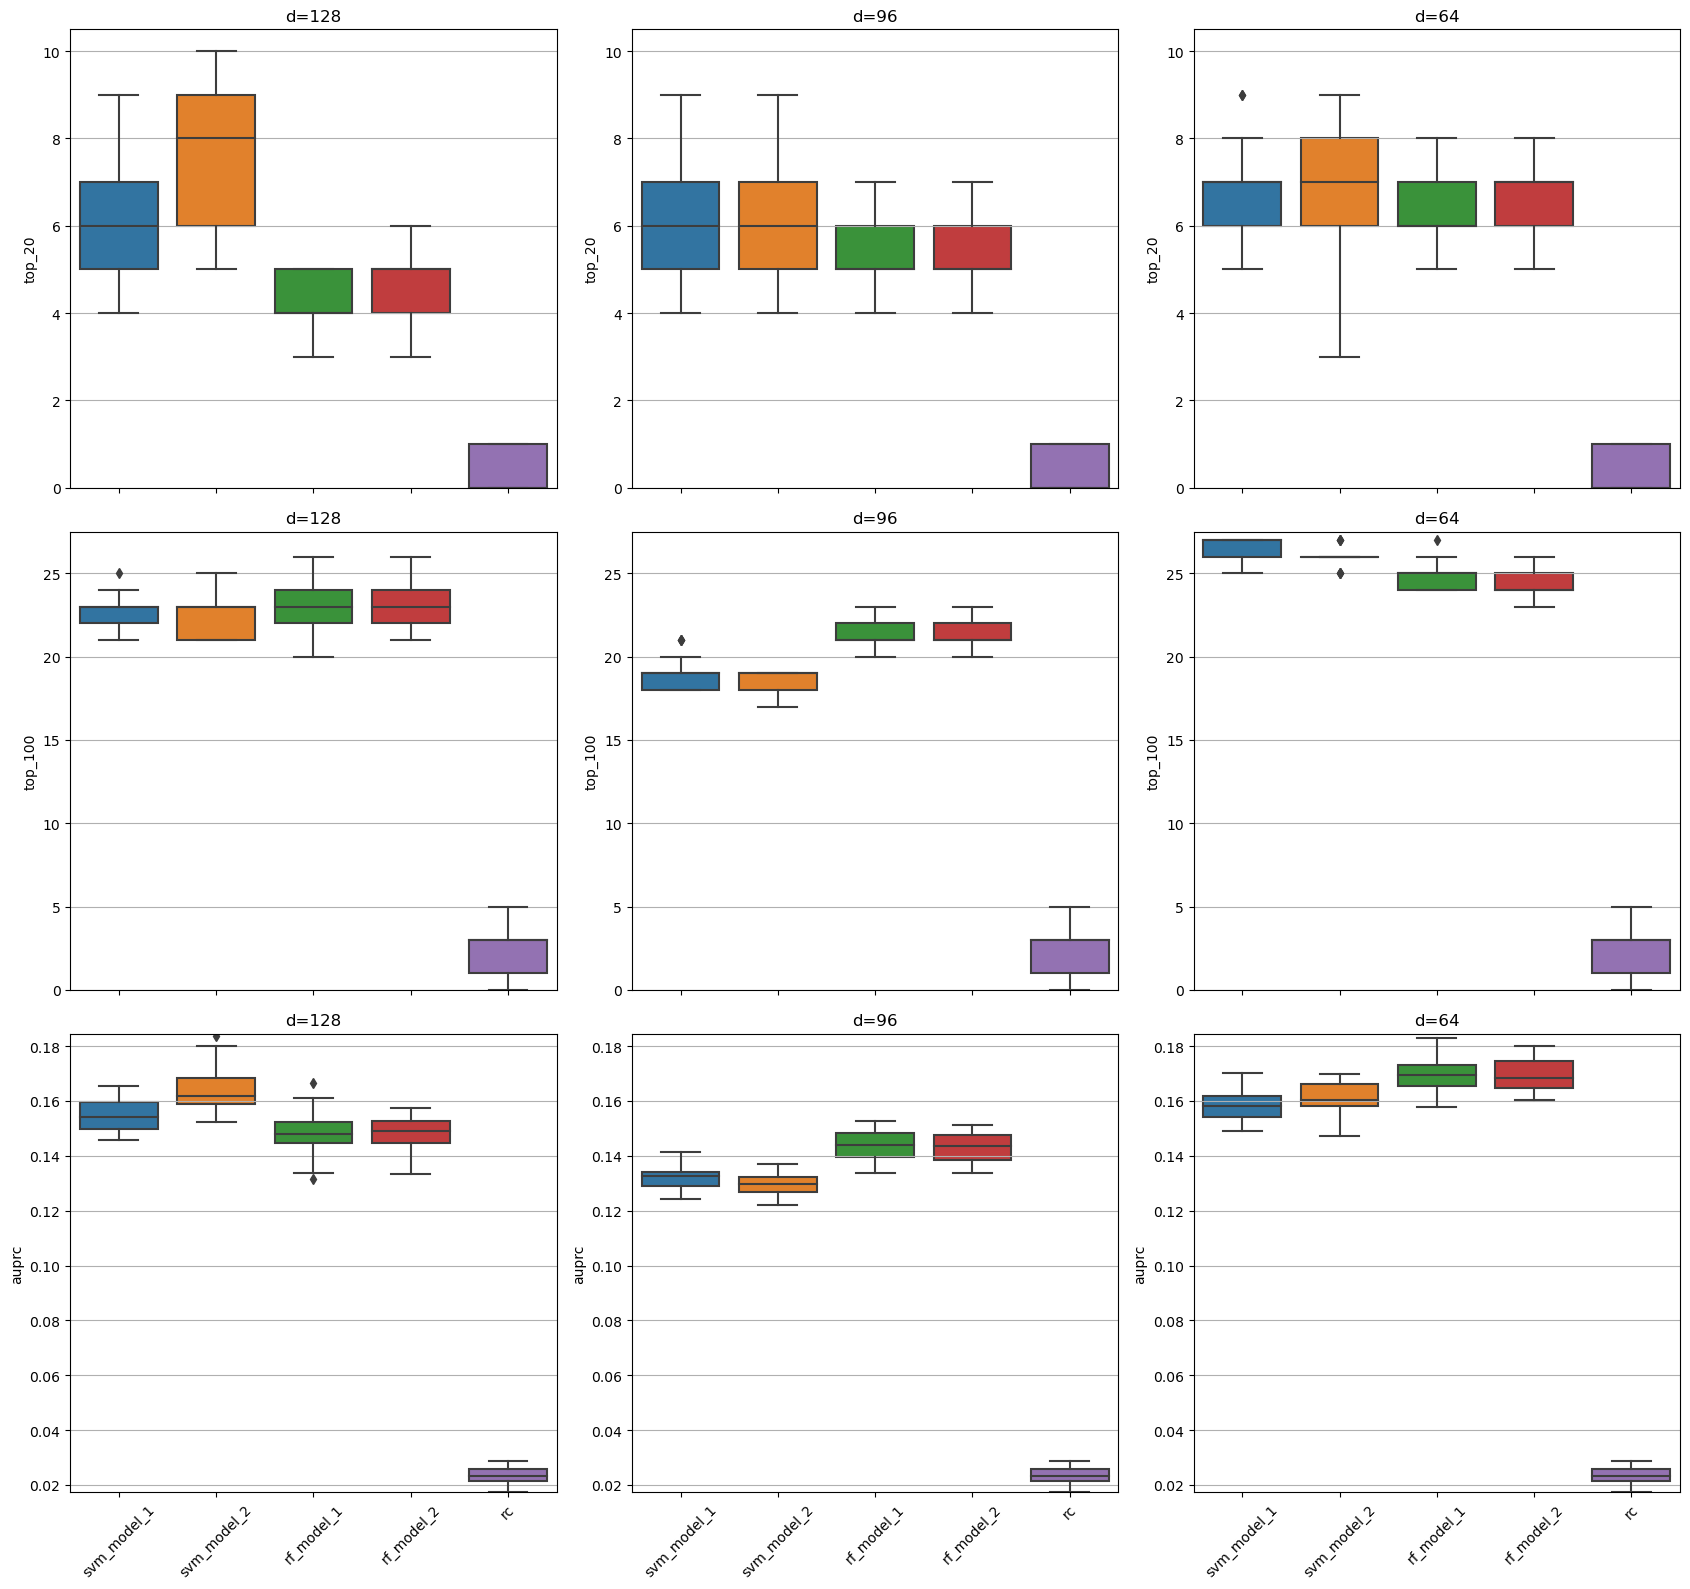

In [14]:
plt.rcParams.update({'font.size': 10}) 

models = ['svm_1', 'svm_2', 'rf_1', 'rf_2', 'rc']
dims = ['128', '96', '64']
base_path = "eval_result_models_"

dfs = []

for model in models:
    for dim in dims:
        # for suffix in suffixes:
        file_name = f"{base_path}{model}_dataset_p_4_q_1_dim_{dim}_walkleng_100_numwalks_500_seed_37.csv"
        file_path = os.path.join(eval_results_path, file_name)
        
        if os.path.exists(file_path):
            df_temp = pd.read_csv(file_path)
            df_temp[f'model_d_{dim}'] = model.replace('_', '_model_')
            dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)

metrics = ['top_20', 'top_100', 'auprc']
y_lims = {
    'top_20': (df['top_20'].min(), df['top_20'].max() + 0.5),
    'top_100': (df['top_100'].min(), df['top_100'].max() + 0.5),
    'auprc': (df['auprc'].min(), df['auprc'].max() + 0.001)
}

fig, axes = plt.subplots(len(metrics), len(dims), figsize=(17, 16), sharex=True)

for i, metric in enumerate(metrics):
    for j, dim in enumerate(dims):
        sns.boxplot(x=f'model_d_{dim}', y=metric, data=df, ax=axes[i, j])
        axes[i, j].set_title(f'd={dim}')
        axes[i, j].set_xlabel("")
        axes[i, j].grid(True, axis='y')
        axes[i, j].set_ylim(y_lims[metric])
        if i == len(metrics) - 1:
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

#### Visualise the aggregated results from all other 6 datasets with different random states and compare the results

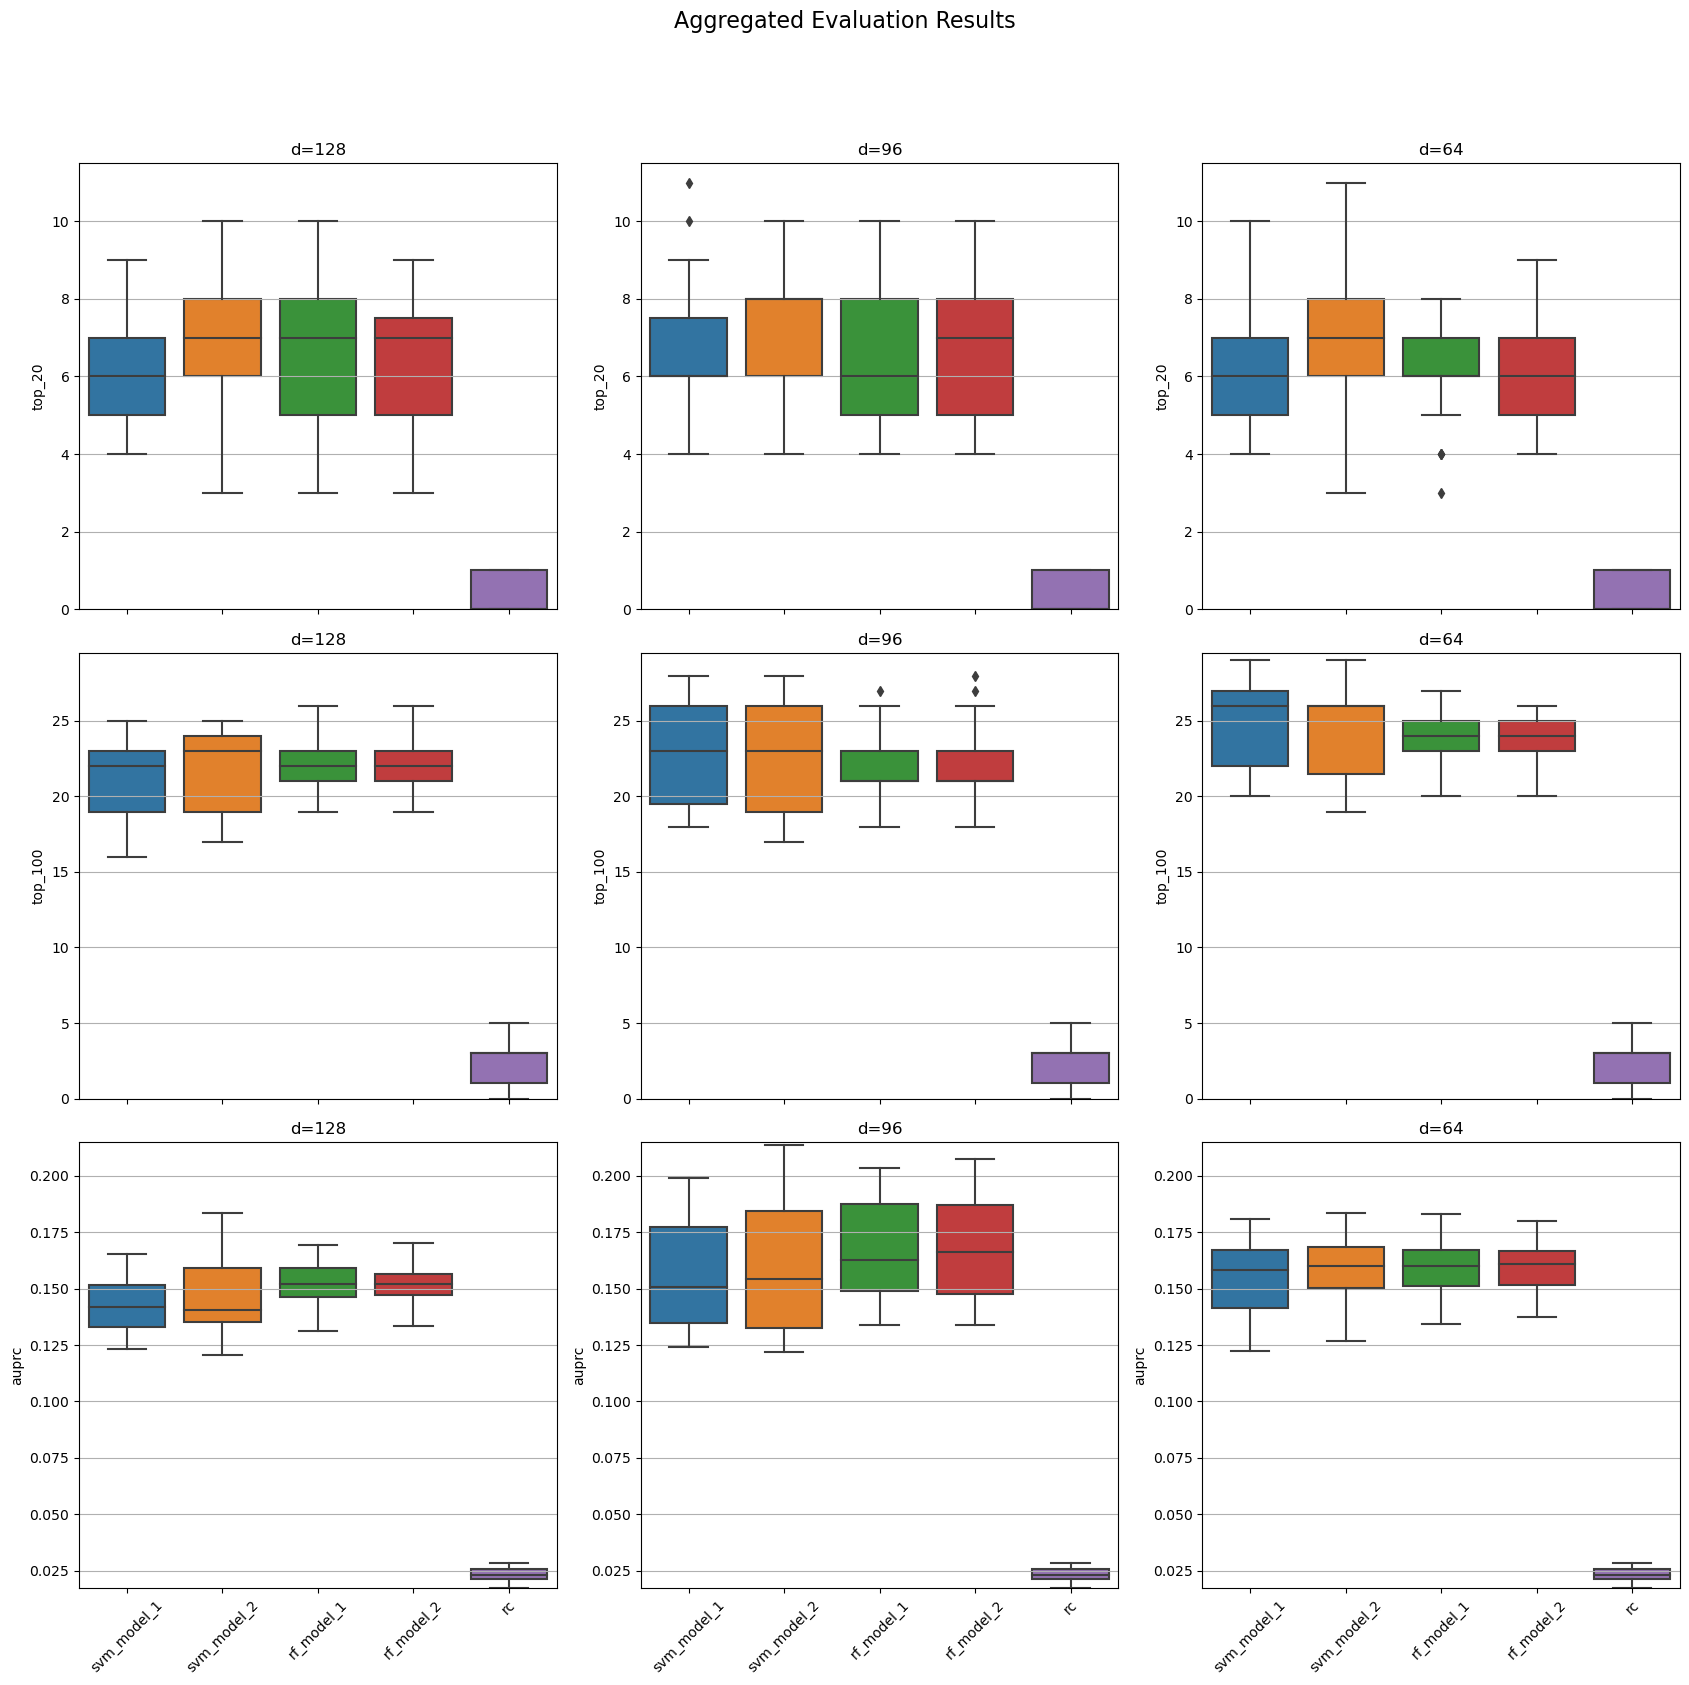

In [12]:
plt.rcParams.update({'font.size': 10}) 

models = ['svm_1', 'svm_2', 'rf_1', 'rf_2', 'rc']
dims = ['128', '96', '64']
base_path = "eval_result_models_"
suffixes = ["", "_seed_44", "_seed_37"]

dfs = []

for model in models:
    for dim in dims:
        for suffix in suffixes:
            file_name = f"{base_path}{model}_dataset_p_4_q_1_dim_{dim}_walkleng_100_numwalks_500{suffix}.csv"
            file_path = os.path.join(eval_results_path, file_name)
            
            if os.path.exists(file_path):
                df_temp = pd.read_csv(file_path)
                df_temp[f'model_d_{dim}'] = model.replace('_', '_model_')
                dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)

metrics = ['top_20', 'top_100', 'auprc']
y_lims = {
    'top_20': (df['top_20'].min(), df['top_20'].max() + 0.5),
    'top_100': (df['top_100'].min(), df['top_100'].max() + 0.5),
    'auprc': (df['auprc'].min(), df['auprc'].max() + 0.001)
}

fig, axes = plt.subplots(len(metrics), len(dims), figsize=(17, 16), sharex=True)

for i, metric in enumerate(metrics):
    for j, dim in enumerate(dims):
        sns.boxplot(x=f'model_d_{dim}', y=metric, data=df, ax=axes[i, j])
        axes[i, j].set_title(f'd={dim}')
        axes[i, j].set_xlabel("")
        axes[i, j].grid(True, axis='y')
        axes[i, j].set_ylim(y_lims[metric])
        if i == len(metrics) - 1:
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=45)

fig.suptitle('Aggregated Evaluation Results', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

#### Choose the final model and save the model for future use

In [13]:
# load the selected models set contain the best model

best_models_file_path = os.path.join(eval_models_path, 'models_svm_2_dataset_p_4_q_1_dim_96_walkleng_100_numwalks_500.pickle')

with open(best_models_file_path, 'rb') as f:
    models = pickle.load(f)

# idenfiy the best model
final_model = models[2]

# save the model
final_model_path = os.path.join('final_model', 'final_model.pickle')

with open(final_model_path, 'wb') as f:
    pickle.dump(final_model, f, pickle.HIGHEST_PROTOCOL)

#### Other Evaluations 

Evaluations of the model by other perspectives:
- Plotting of PRC curve of the final model
- Evaluation by Drug Associated Genes
- Plot feature importances and study the important features

#### Plot AUPRC of the final model

Input:	Final model, dataset of the respective final model

Process:	Split dataset into training and testing. Calculate the PRC on testing dataset

Output:	a plot to show the PRC, and the AUPRC result

In [99]:
# load datasets of the final model

dataset_filename = 'dataset_p_4_q_1_dim_96_walkleng_100_numwalks_500.csv'
file_path = os.path.join('data', 'datasets', dataset_filename)
dataset = pd.read_csv(file_path)
# Splitting the dataset
X = dataset.drop(['id', 'y'], axis=1)
y = dataset['y']

# split the dataset into training and testing with 80% to 20% proportion and randomly shuffle the data
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=37,stratify=y)


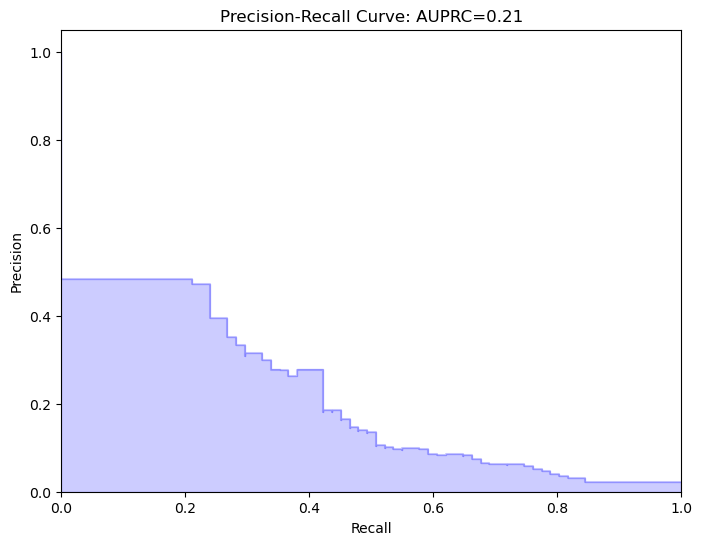

In [16]:
y_true = test_y
y_scores = final_model.predict_proba(test_X)[:,1]

precision, recall, _ = precision_recall_curve(y_true, y_scores)
auprc = average_precision_score(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve: AUPRC={auprc:.2f}')
plt.show()

#### Evaluate model performance with Drug Associate Genes 

Introduction:

The aim is to see the performance of the best performance models on RA drug associated genes. This serves as a evaluation by external real world data. The positive label are replaced according to the drug associated genes. Performance is evaluated by how many hits on the top 20 and top 100 predictions. And then compare the result with random classifer.  

Input:	Best performing models that has already fitted, Dataset of the respective models, genes associated with RA drugs 

Process:	
- Relabel positive data with RA drug association. y = 1 if the gene is related to RA drugs, 0 for the rest
- Split dataset and use only the testing dataset
- Make prediction from the best performing models on testing dataset
- Count performance by scorers: top 20 and top 100 hits  
- Use random classifier to do the prediction, for comparison

Quality control:	Count the sum of the relabelled positive should be the same as the number of drug associated genes

Output:	Top 20 and top 100 hit scores


In [101]:
# define helper function to positive labelling data
def positive_labelling (data, positive_ids):
    data = data.copy()
    def set_y_value(row):
        if row['id'] in positive_ids:
            return 1
        else:
            return 0

    data['y'] = data.apply(set_y_value, axis=1)

    return data

In [102]:
# load the disease genetic association list
drug_asso= pd.read_csv(os.path.join('open_targets_data', 'RADrugAssociationAll.csv'))
drug_asso_id = drug_asso['target_id'].values.tolist()

In [103]:
# load datasets

dataset_filename = 'dataset_p_4_q_1_dim_96_walkleng_100_numwalks_500.csv'
file_path = os.path.join('data', 'datasets', dataset_filename)
dataset = pd.read_csv(file_path)
dataset = dataset.drop(['y'], axis = 1)

In [104]:
dataset_y_drug = positive_labelling(dataset, drug_asso_id)

In [105]:
# Splitting the dataset
X = dataset_y_drug.drop(['id', 'y'], axis=1)
y = dataset_y_drug['y']

# split the dataset into training and testing with 80% to 20% proportion with stratification
_, test_X, _, test_drug_y = train_test_split(X,y, test_size=0.2, random_state=37,stratify=y)

In [106]:
# verify the size of the testing set

len(test_X)

3242

In [107]:
# verify the number of drug associated genes in the testing set

test_drug_y.sum()

51

In [108]:
# load the selected models set contain the best model

best_models_file_path = os.path.join(eval_models_path, 'models_svm_2_dataset_p_4_q_1_dim_96_walkleng_100_numwalks_500.pickle')

with open(best_models_file_path, 'rb') as f:
    models = pickle.load(f)
    
# configure scorers and parameters 
scorers_with_args = [
    ('top_20', topk, {'top_k': 20}),
    ('top_100', topk, {'top_k': 100})
]

results = []

for model in models:
    result_for_a_model = evaluate(model, test_X, test_drug_y, scorers_with_args)
    print(result_for_a_model)
    results.append(result_for_a_model)

results_drug_asso_best_model = pd.DataFrame(results)

{'top_20': 1, 'top_100': 12}
{'top_20': 2, 'top_100': 12}
{'top_20': 1, 'top_100': 10}
{'top_20': 1, 'top_100': 12}
{'top_20': 1, 'top_100': 12}
{'top_20': 2, 'top_100': 12}
{'top_20': 2, 'top_100': 12}
{'top_20': 1, 'top_100': 12}
{'top_20': 2, 'top_100': 13}
{'top_20': 2, 'top_100': 12}
{'top_20': 4, 'top_100': 13}
{'top_20': 2, 'top_100': 13}
{'top_20': 3, 'top_100': 12}
{'top_20': 2, 'top_100': 12}
{'top_20': 3, 'top_100': 12}
{'top_20': 1, 'top_100': 12}
{'top_20': 2, 'top_100': 11}
{'top_20': 3, 'top_100': 12}
{'top_20': 2, 'top_100': 14}
{'top_20': 3, 'top_100': 12}
{'top_20': 2, 'top_100': 12}
{'top_20': 1, 'top_100': 13}
{'top_20': 2, 'top_100': 12}
{'top_20': 3, 'top_100': 13}
{'top_20': 2, 'top_100': 14}


In [97]:
# calcualte the mean of the performance

print(results_drug_asso_best_model.mean())

top_20      2.00
top_100    12.24
dtype: float64


In [110]:
# use random classifier to test on the drug association data
rc_models = []

for random_state in random_states:
    clf = RandomClassifier(pos_threshold=0.0157, random_state= random_state)
    rc_models.append(clf)

rc_results = []

for model in rc_models:
    result_for_a_model = evaluate(model, test_X, test_drug_y, scorers_with_args)
    print(result_for_a_model)
    rc_results.append(result_for_a_model)

results_drug_asso_rc_model = pd.DataFrame(rc_results)
print(results_drug_asso_rc_model.mean())


{'top_20': 0, 'top_100': 0}
{'top_20': 0, 'top_100': 0}
{'top_20': 0, 'top_100': 1}
{'top_20': 0, 'top_100': 1}
{'top_20': 0, 'top_100': 1}
{'top_20': 1, 'top_100': 3}
{'top_20': 1, 'top_100': 1}
{'top_20': 0, 'top_100': 1}
{'top_20': 0, 'top_100': 0}
{'top_20': 0, 'top_100': 2}
{'top_20': 0, 'top_100': 3}
{'top_20': 0, 'top_100': 1}
{'top_20': 0, 'top_100': 1}
{'top_20': 0, 'top_100': 0}
{'top_20': 0, 'top_100': 1}
{'top_20': 0, 'top_100': 0}
{'top_20': 0, 'top_100': 3}
{'top_20': 0, 'top_100': 1}
{'top_20': 0, 'top_100': 1}
{'top_20': 0, 'top_100': 0}
{'top_20': 0, 'top_100': 2}
{'top_20': 1, 'top_100': 2}
{'top_20': 1, 'top_100': 3}
{'top_20': 0, 'top_100': 0}
{'top_20': 0, 'top_100': 1}
top_20     0.16
top_100    1.16
dtype: float64


#### Plot the feature importance graph from sampled Random Forest models

Introduction:

Some feature vectors may contribute significantly to the classification. These features could be further studied by researchers to find out the interpretability of those important data features

Input:	a trained random forest model

Process:	for each tree in the random forest, calculate the average of the feature importance score of each feature

Output:	a plot to show the average contribution (0.0-1.0) of each feature vector to the classification



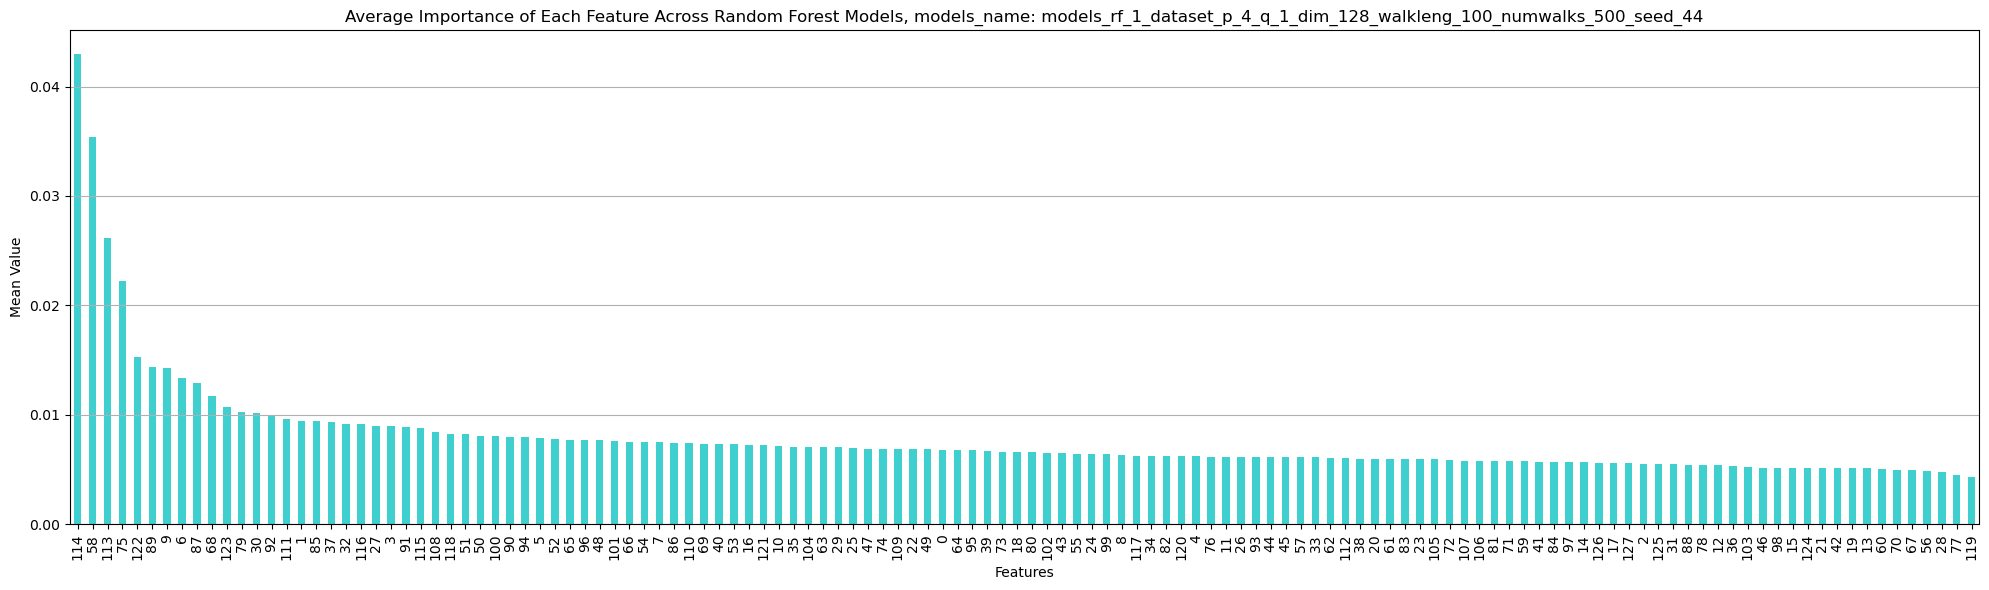

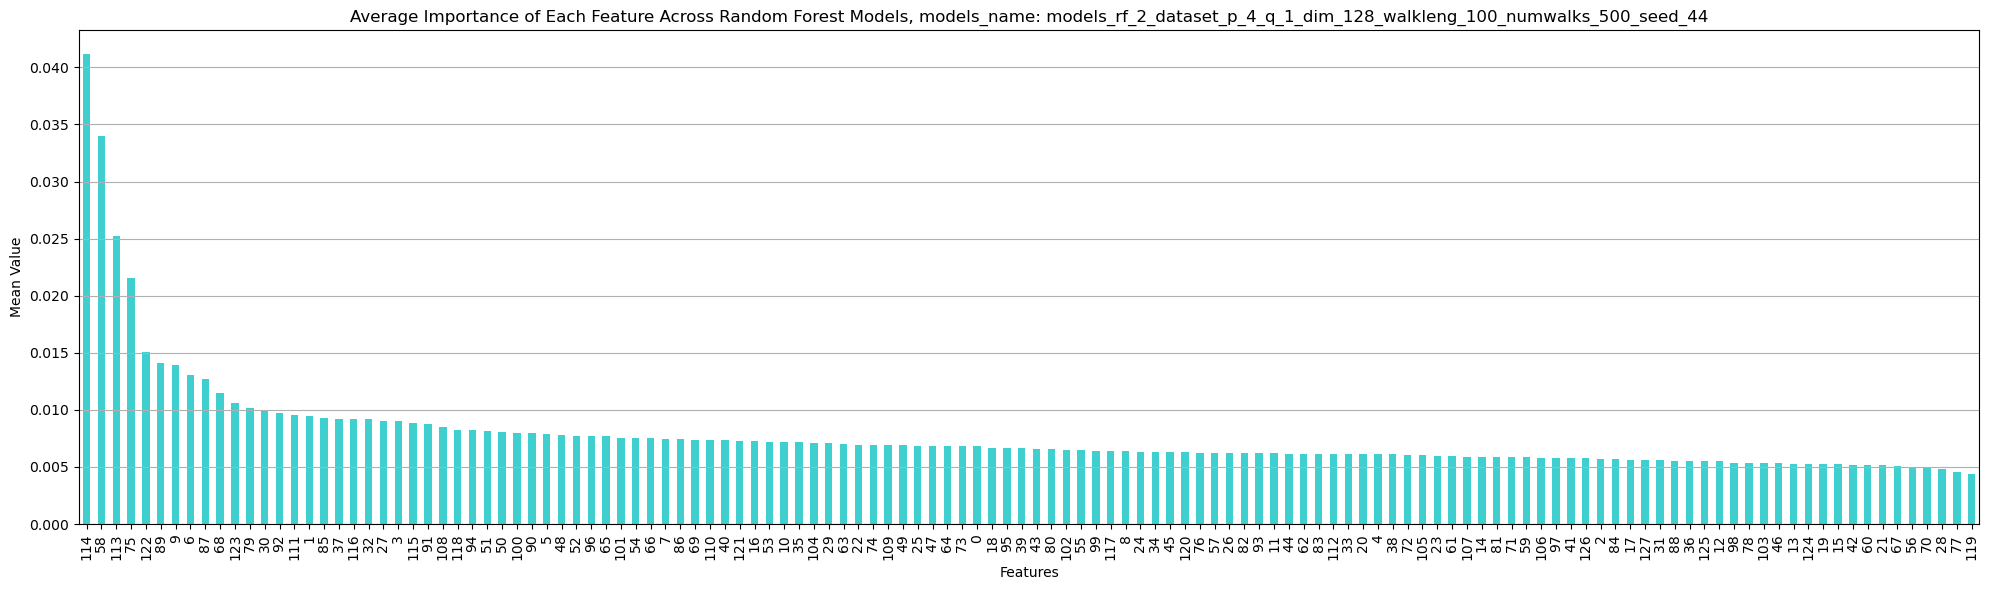

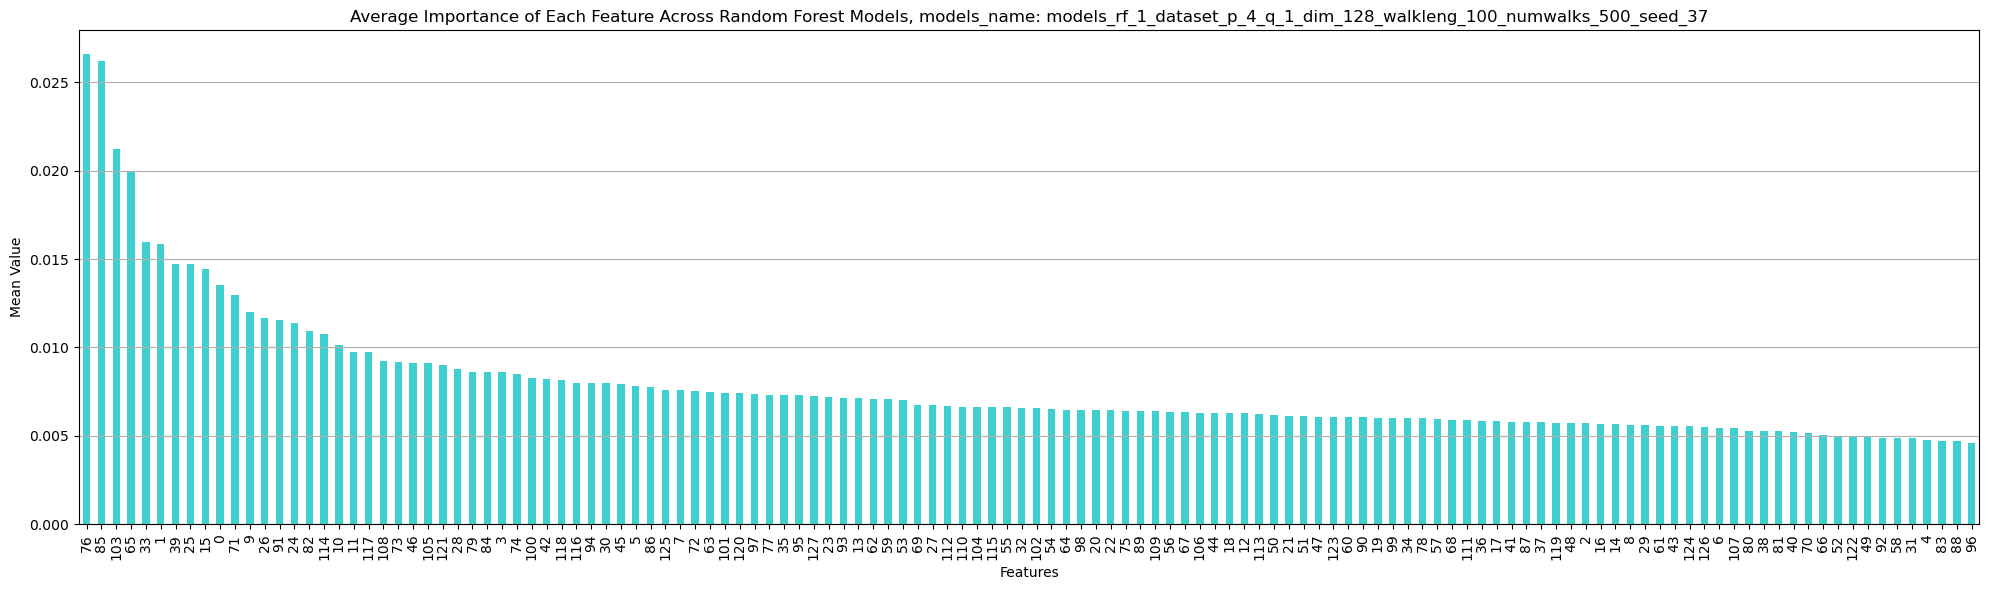

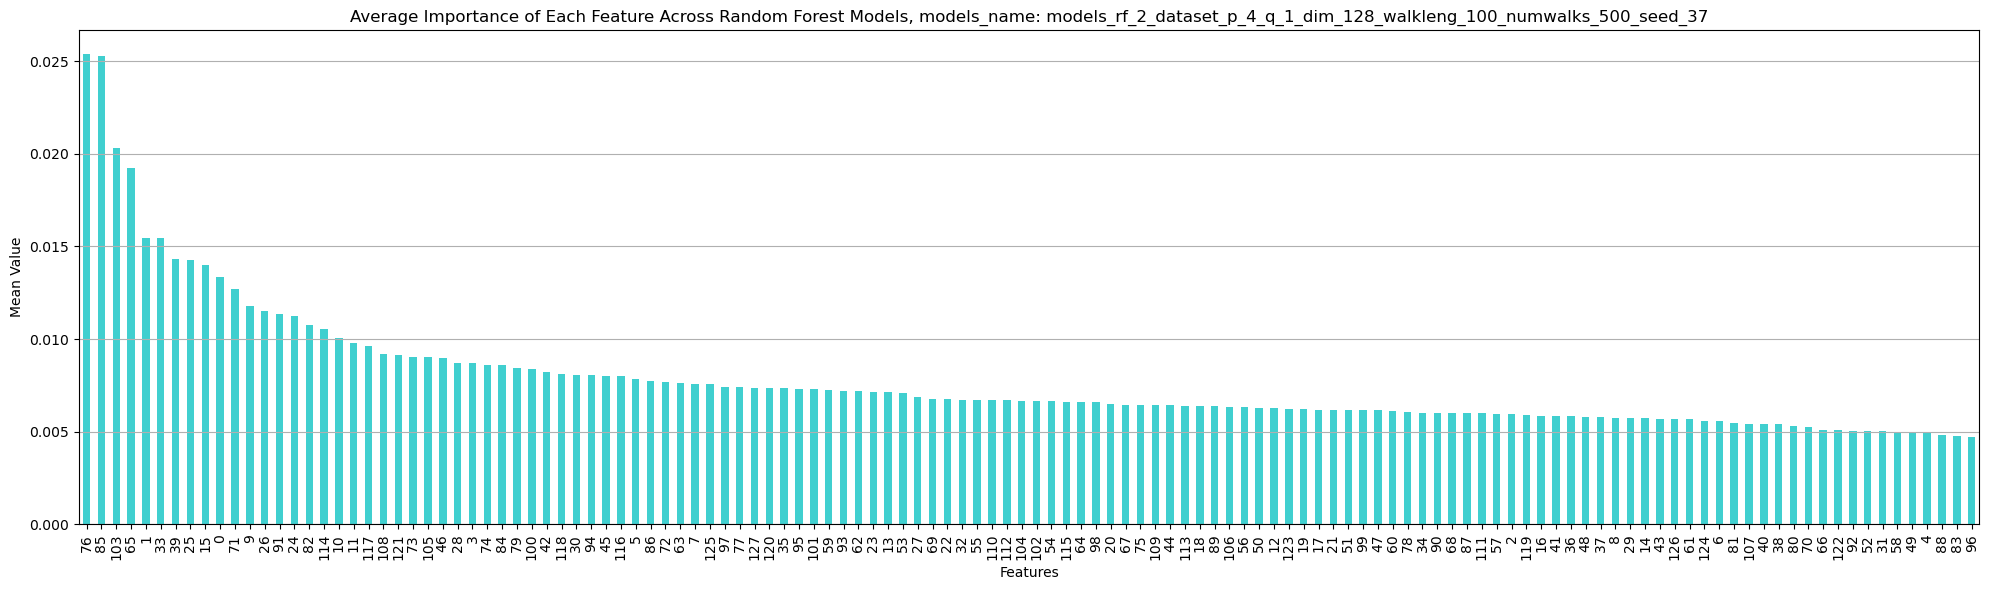

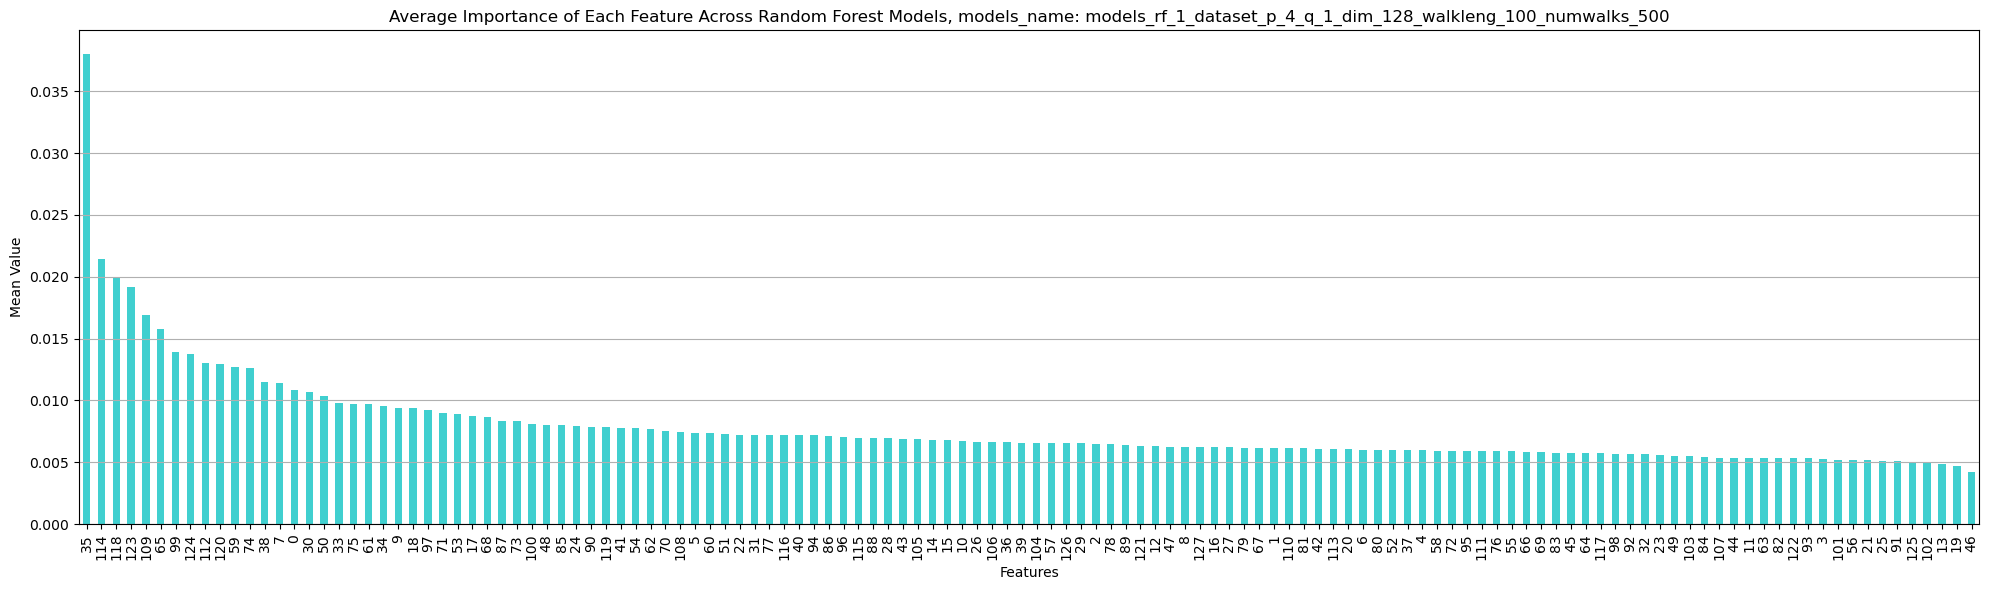

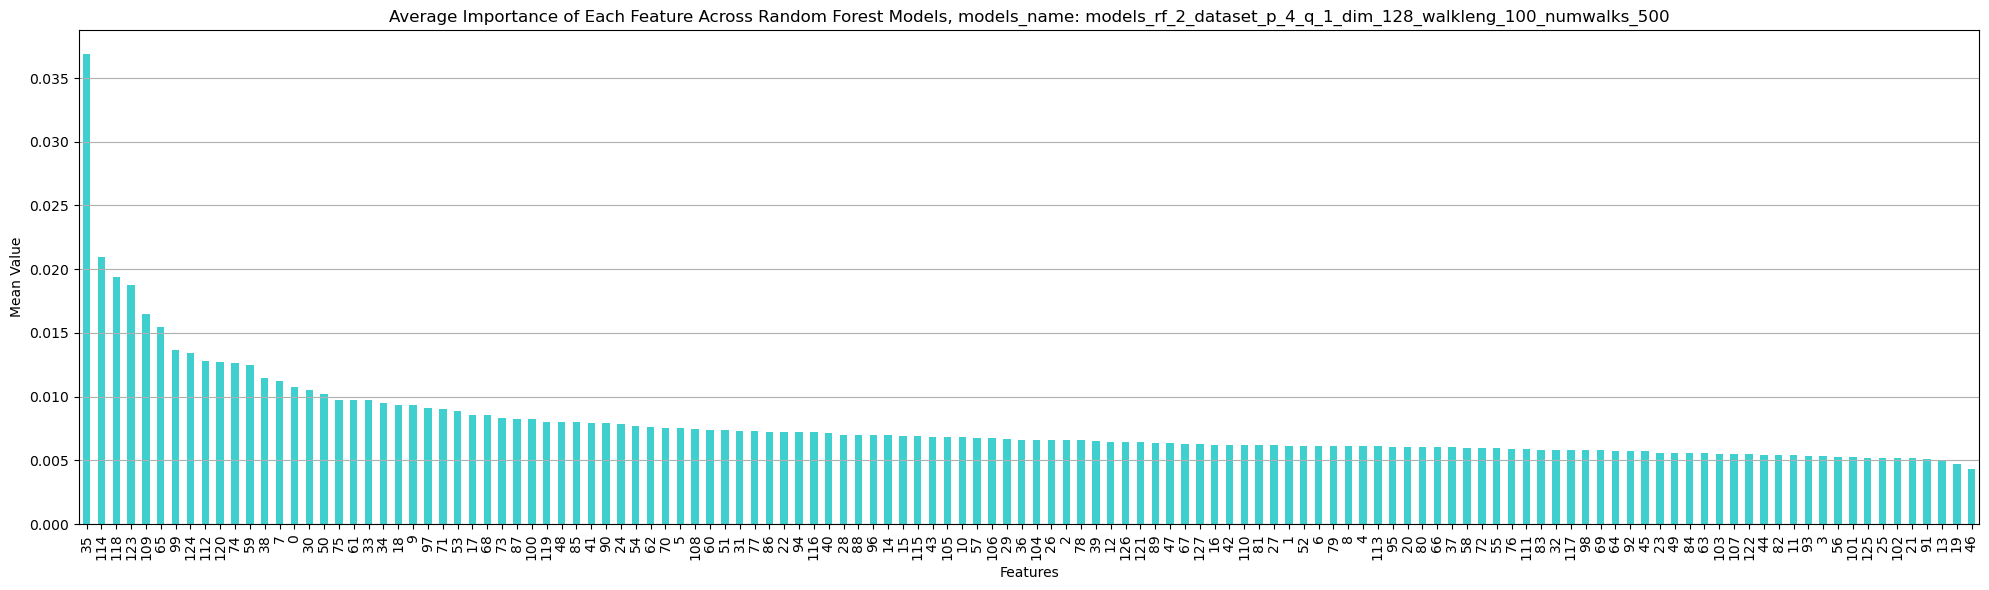

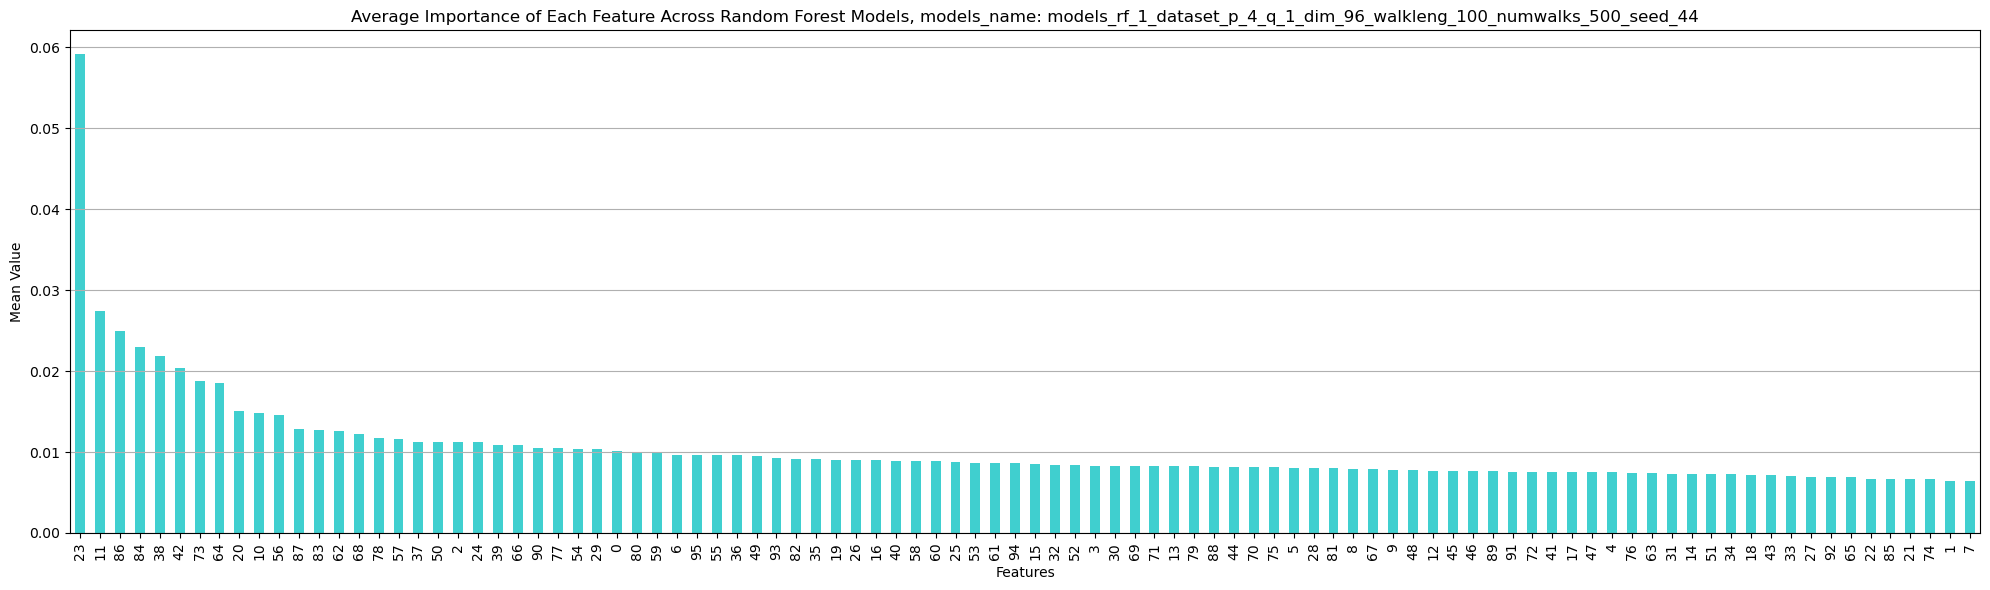

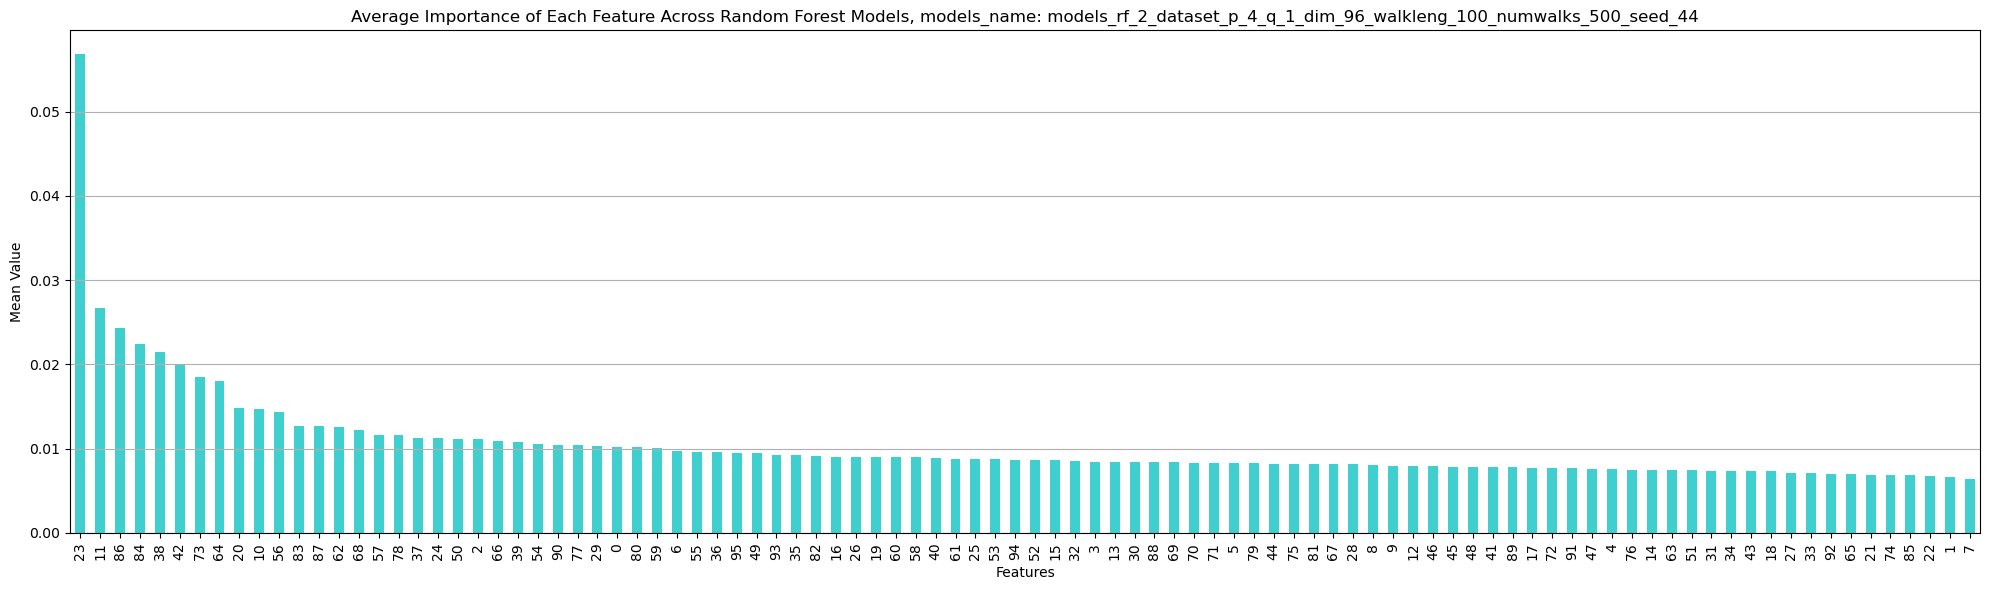

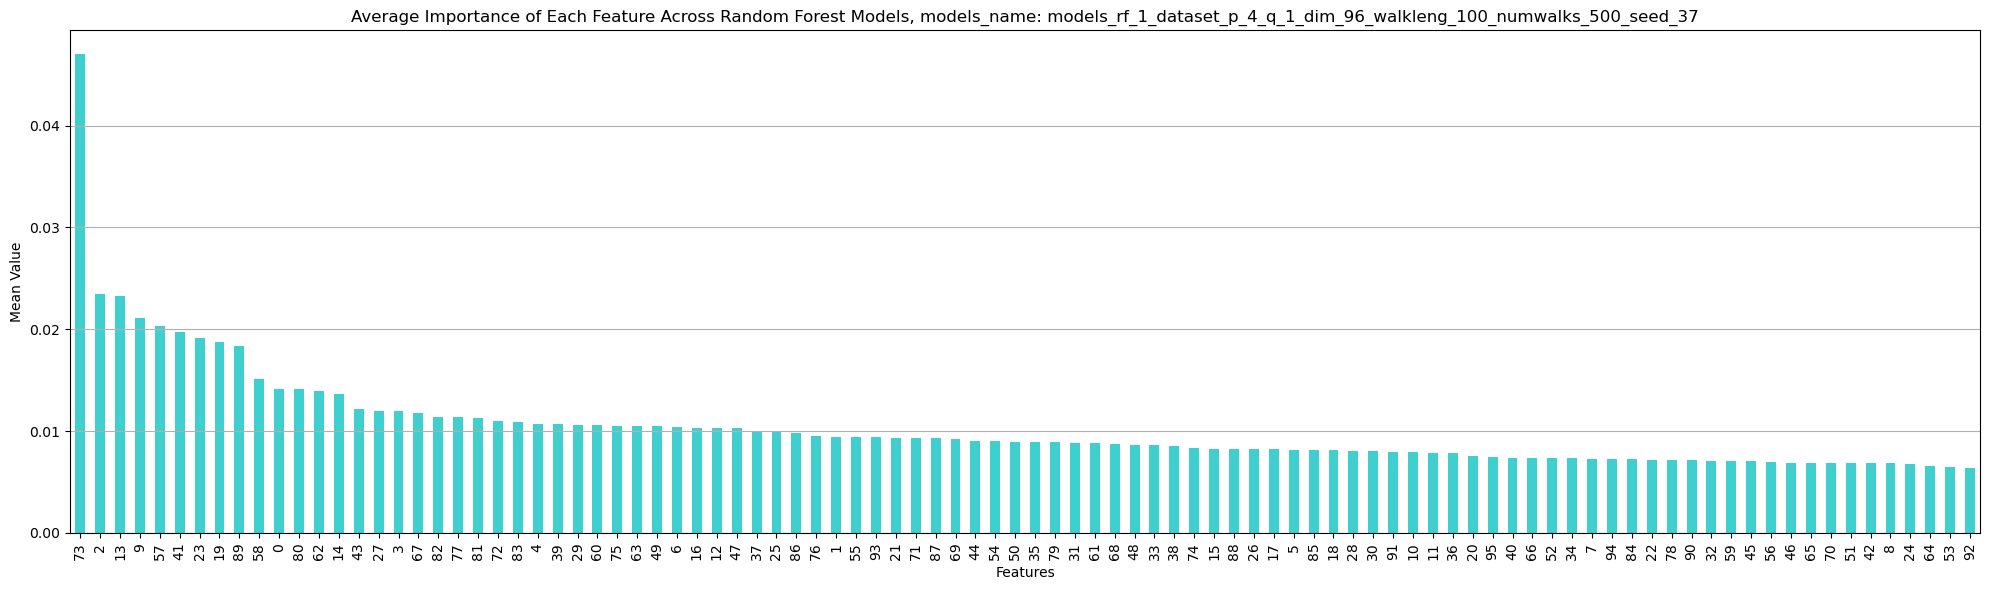

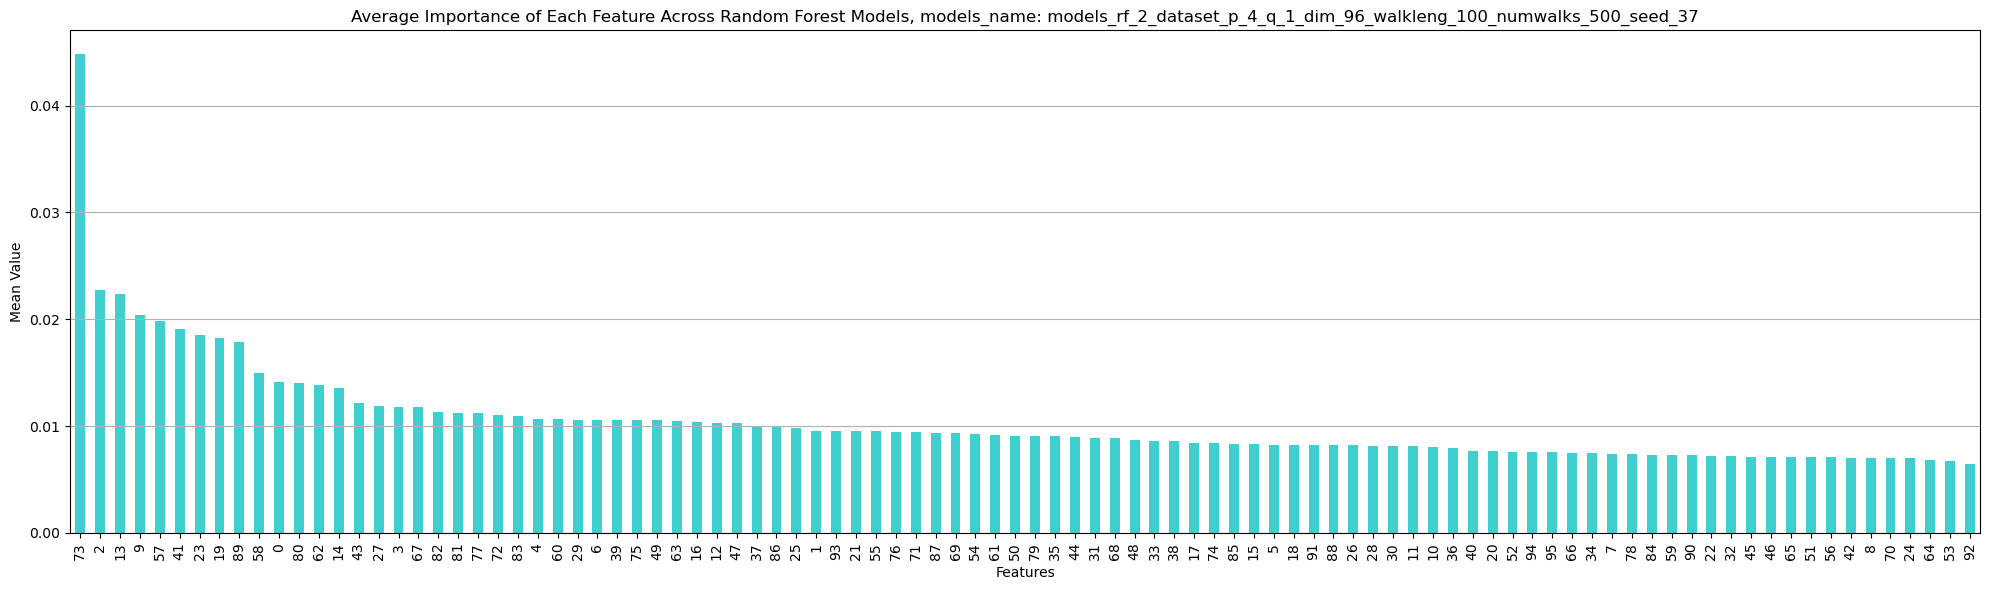

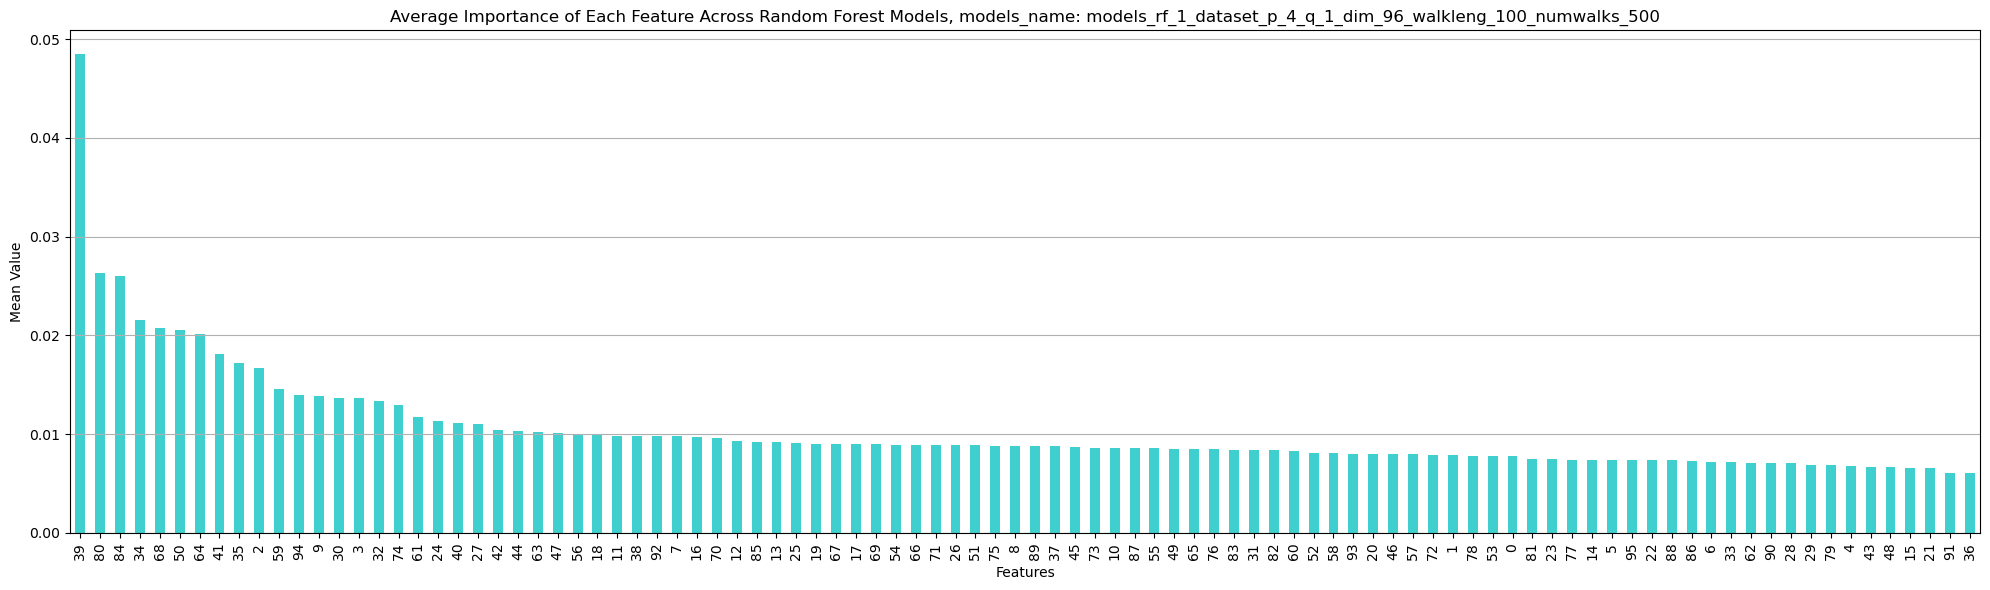

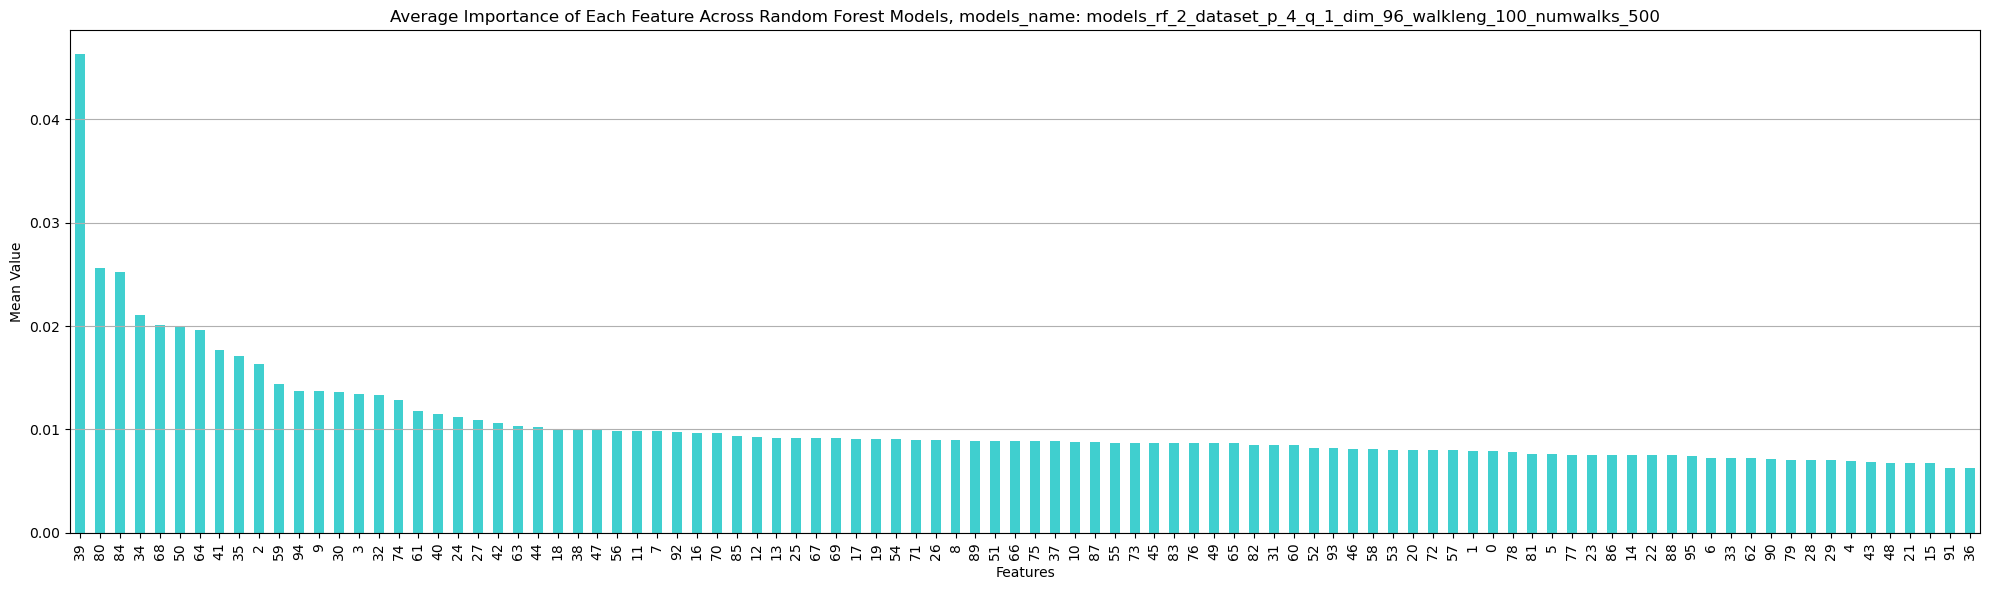

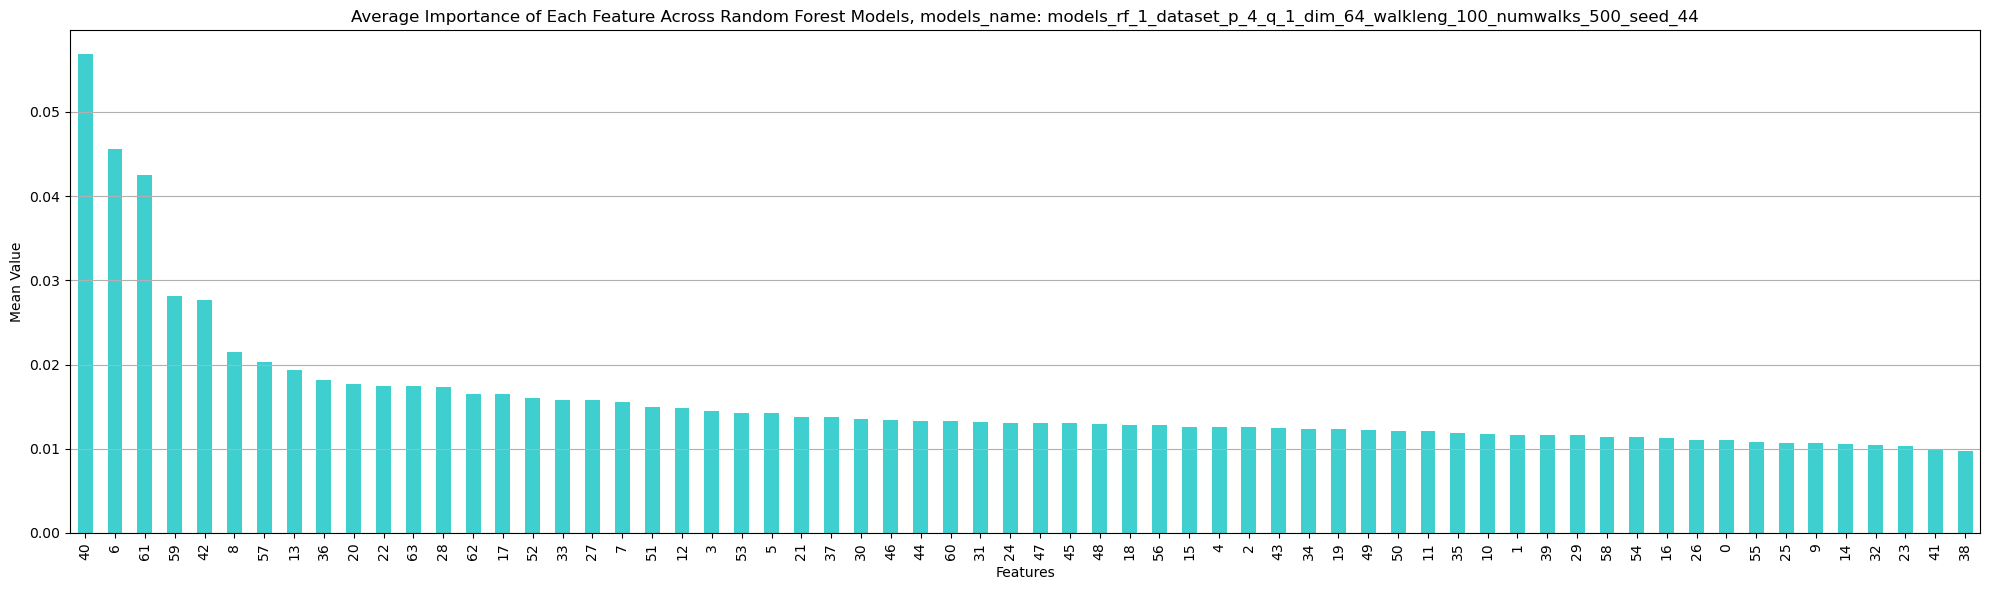

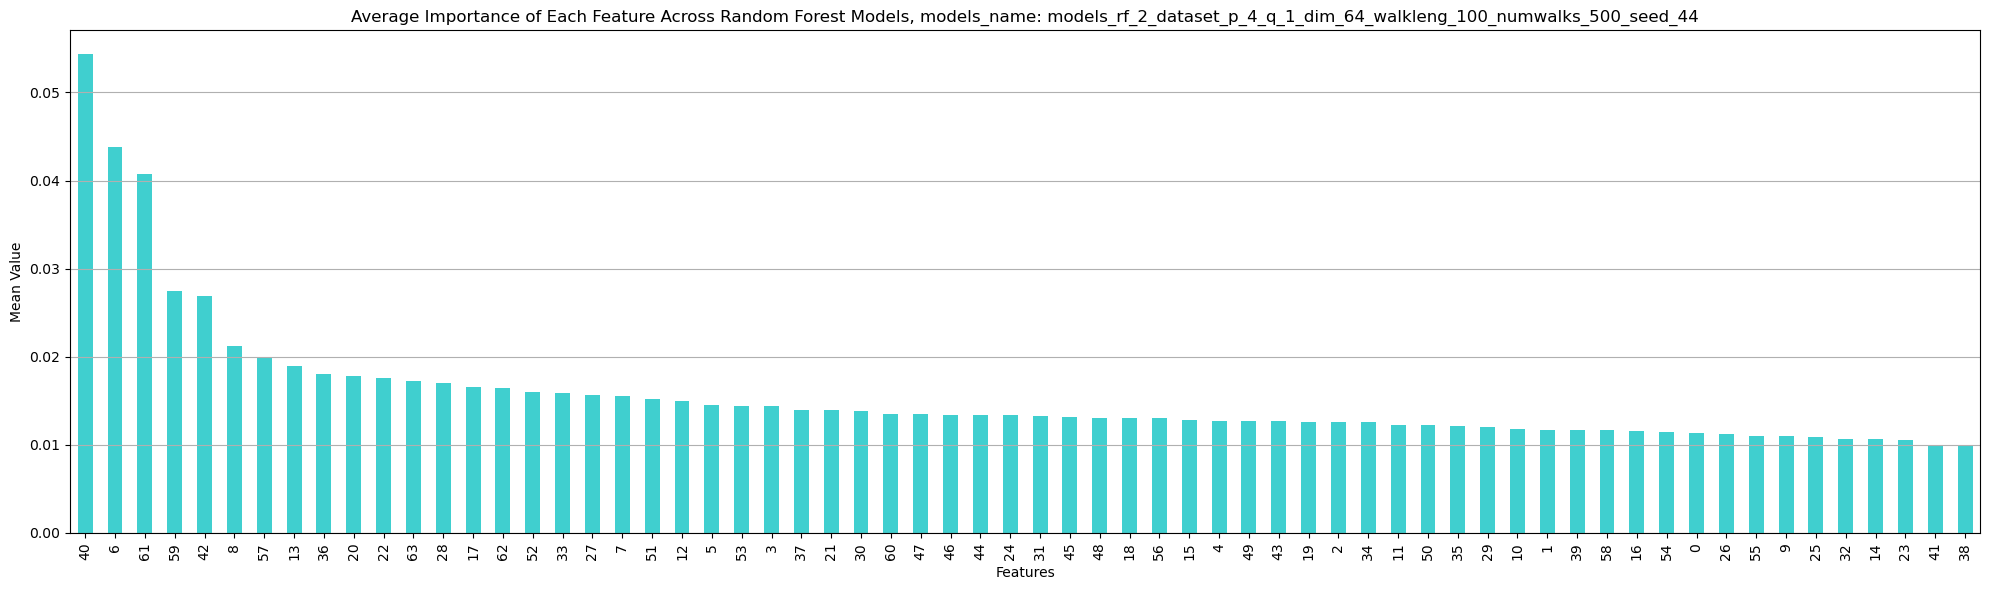

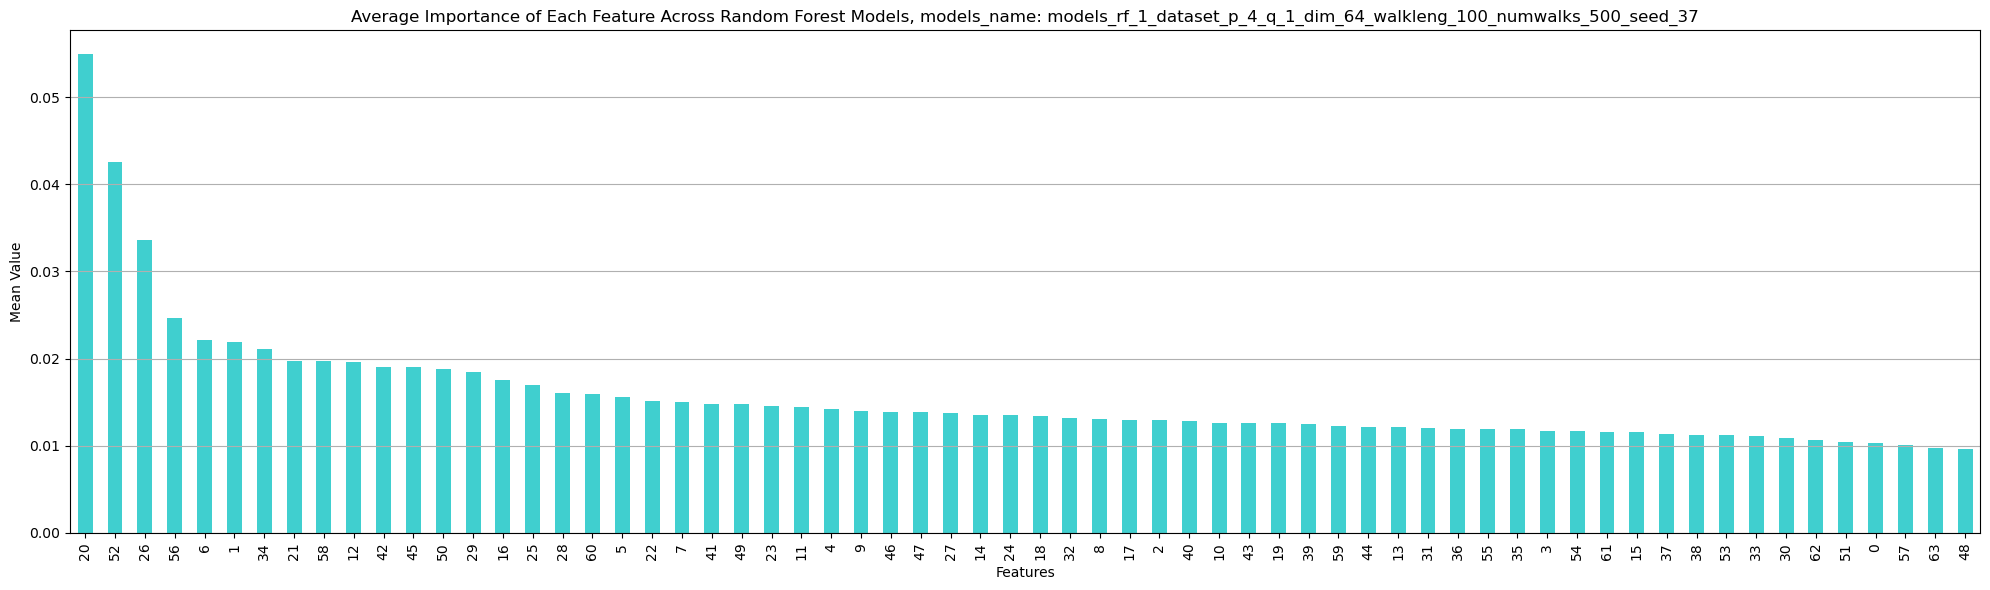

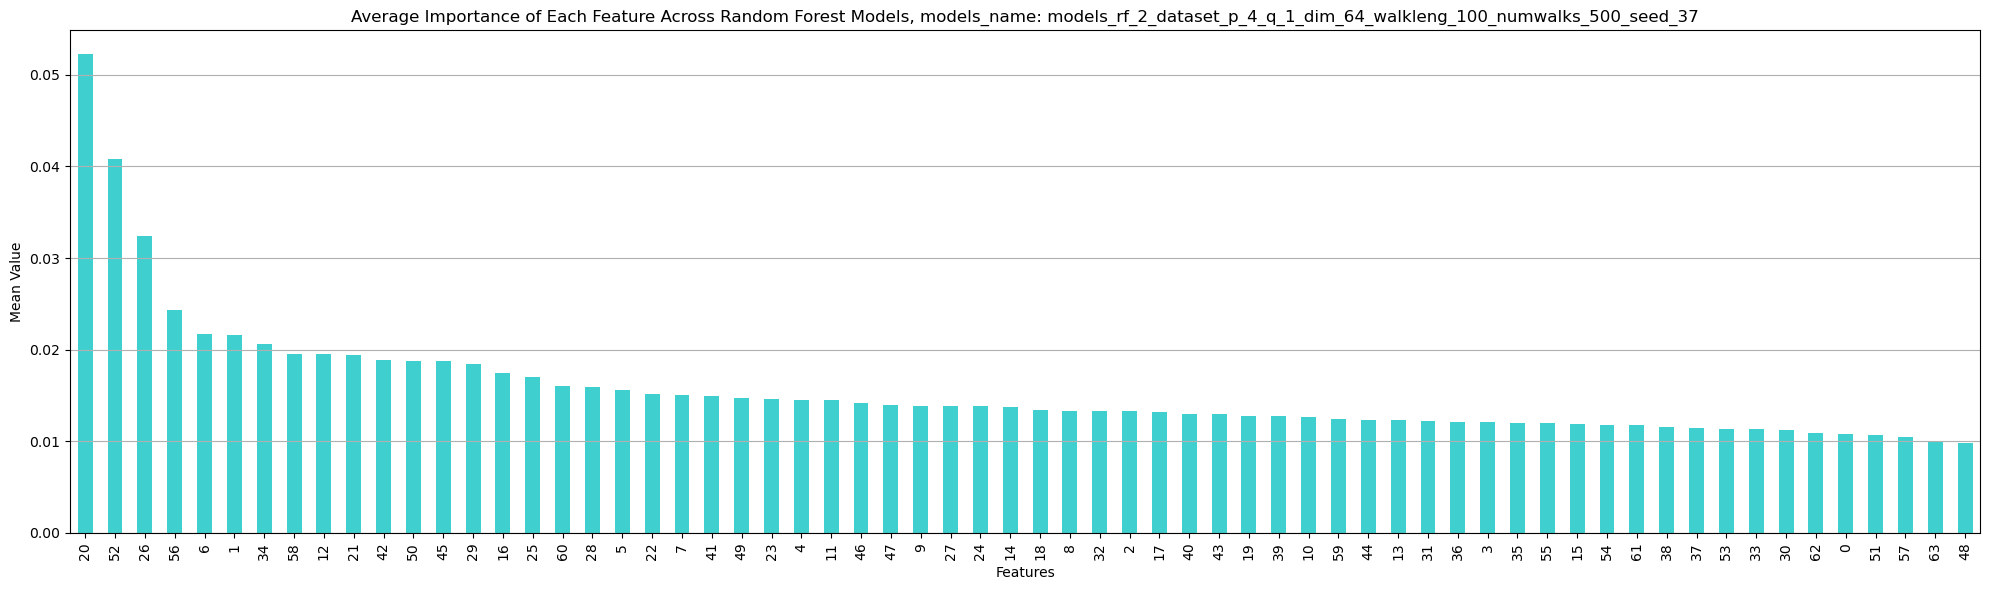

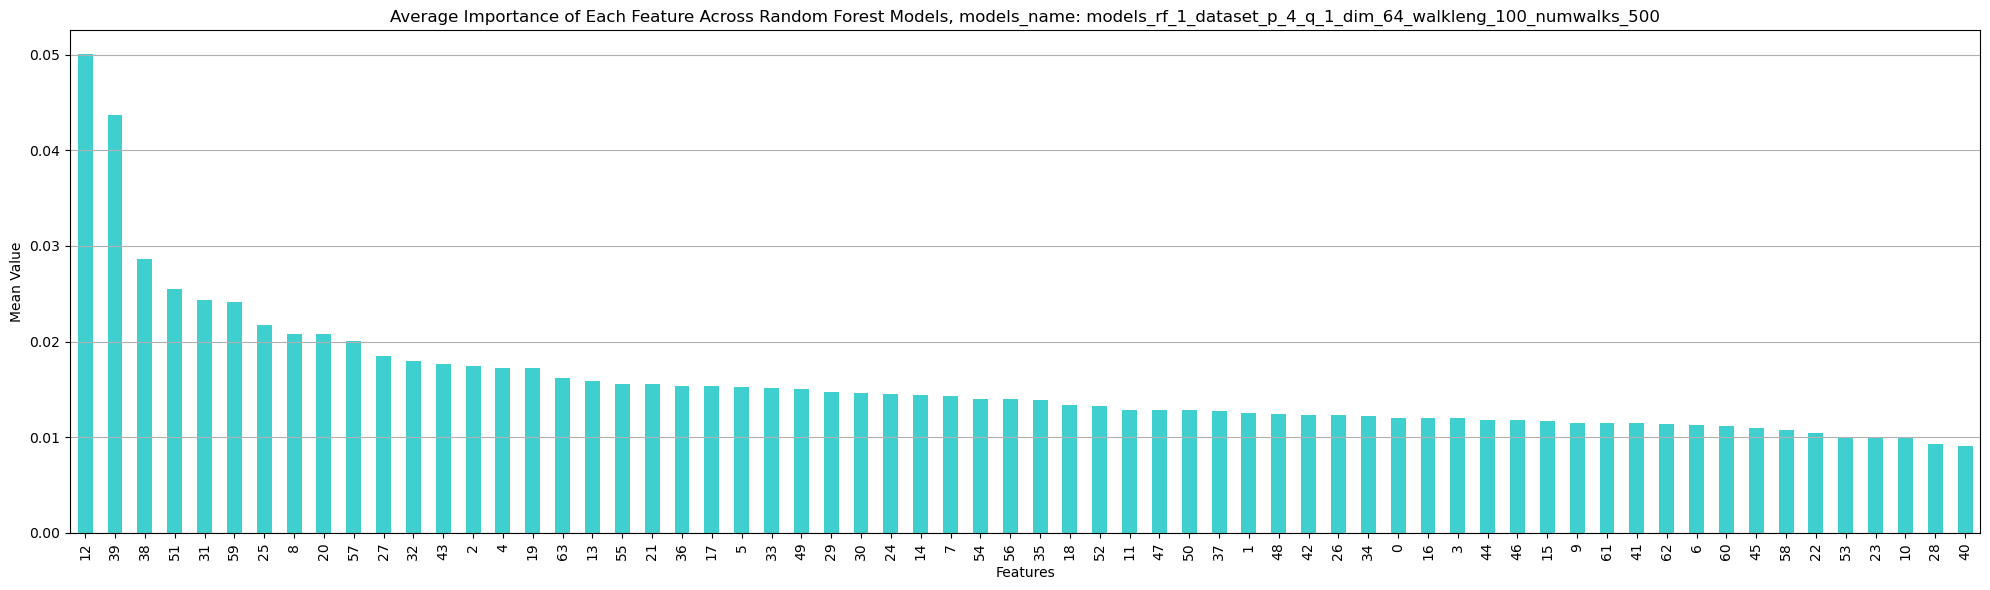

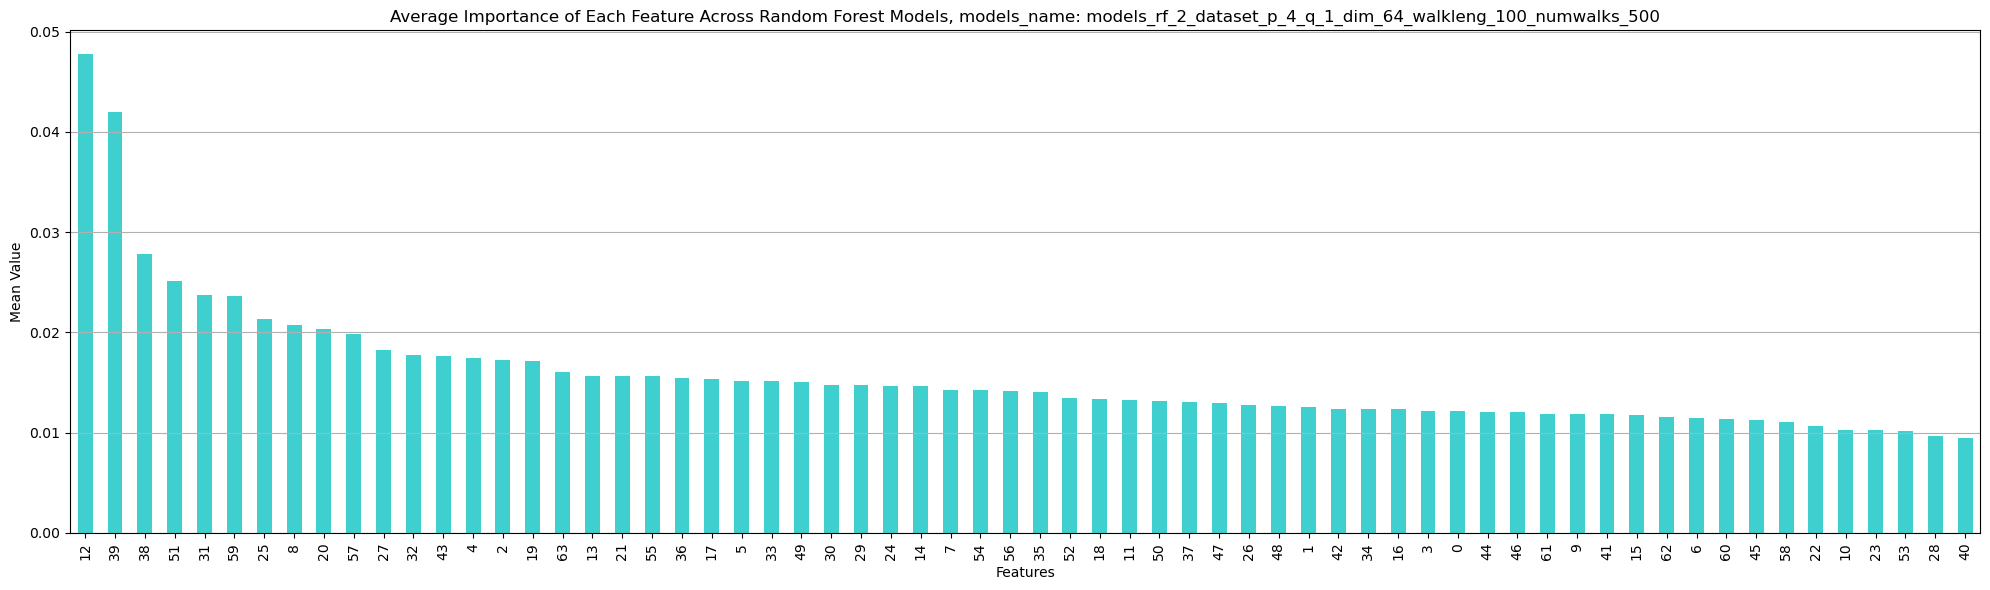

In [12]:
# Sample models: the Random Forest (rf_models_1) for dataset dimension = 96 

rf_sample_models_files = [
                          'models_rf_1_dataset_p_4_q_1_dim_128_walkleng_100_numwalks_500_seed_44.pickle', 
                          'models_rf_2_dataset_p_4_q_1_dim_128_walkleng_100_numwalks_500_seed_44.pickle', 
                          'models_rf_1_dataset_p_4_q_1_dim_128_walkleng_100_numwalks_500_seed_37.pickle', 
                          'models_rf_2_dataset_p_4_q_1_dim_128_walkleng_100_numwalks_500_seed_37.pickle', 
                          'models_rf_1_dataset_p_4_q_1_dim_128_walkleng_100_numwalks_500.pickle',
                          'models_rf_2_dataset_p_4_q_1_dim_128_walkleng_100_numwalks_500.pickle',                          
                          'models_rf_1_dataset_p_4_q_1_dim_96_walkleng_100_numwalks_500_seed_44.pickle',
                          'models_rf_2_dataset_p_4_q_1_dim_96_walkleng_100_numwalks_500_seed_44.pickle',                           
                          'models_rf_1_dataset_p_4_q_1_dim_96_walkleng_100_numwalks_500_seed_37.pickle', 
                          'models_rf_2_dataset_p_4_q_1_dim_96_walkleng_100_numwalks_500_seed_37.pickle',
                          'models_rf_1_dataset_p_4_q_1_dim_96_walkleng_100_numwalks_500.pickle',
                          'models_rf_2_dataset_p_4_q_1_dim_96_walkleng_100_numwalks_500.pickle',
                          'models_rf_1_dataset_p_4_q_1_dim_64_walkleng_100_numwalks_500_seed_44.pickle', 
                          'models_rf_2_dataset_p_4_q_1_dim_64_walkleng_100_numwalks_500_seed_44.pickle', 
                          'models_rf_1_dataset_p_4_q_1_dim_64_walkleng_100_numwalks_500_seed_37.pickle', 
                          'models_rf_2_dataset_p_4_q_1_dim_64_walkleng_100_numwalks_500_seed_37.pickle', 
                          'models_rf_1_dataset_p_4_q_1_dim_64_walkleng_100_numwalks_500.pickle',
                          'models_rf_2_dataset_p_4_q_1_dim_64_walkleng_100_numwalks_500.pickle'
                          ]

for rf_sample_models_file in rf_sample_models_files:
    models_name = os.path.splitext(rf_sample_models_file)[0]

    with open(os.path.join(eval_models_path, rf_sample_models_file), 'rb') as f:
        rf_sample_models = pickle.load(f)

    sorted_means = get_avg_feature_importances(rf_sample_models)

    # Plot the graph
    sorted_means.plot(kind='bar', color='c', alpha=0.75, figsize=(20,6))
    plt.title(f'Average Importance of Each Feature Across Random Forest Models, models_name: {models_name}')
    plt.ylabel('Mean Value')
    plt.xlabel('Features')
    plt.grid(axis='y')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()